In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model, model_selection, metrics, ensemble, mixture
import random
from decimal import Decimal
import math as m
import matplotlib.pyplot as plt
from scipy import stats


PROBLEM 1

In [2]:
ex = pd.read_csv("hw3-data/Prob1_X.csv", header = None)
why = pd.read_csv("hw3-data/Prob1_Y.csv", header = None)

In [3]:
lr = linear_model.LinearRegression()
metrics.accuracy_score(why, np.sign(lr.fit(ex, why).predict(ex)))

0.808

In [4]:
#GETTING BOOT STRAPPED SET
def split_sample(y, x, w):
    #GETTING BAGGED SET, ALLOW DUPLICATES
    why_train = y.sample(n = len(y), replace = True, weights = w)
    why_train = why_train.sort_index()

    #ONLY WANT EX ROWS THAT ARE IN WHY
    ex_train = x[x.index.isin(why_train.index)]

    #NEED TO HAVE DUPLICATES WHERE IT MAKES SENSE
    for i in set(why_train.index):
        if (why_train.index == i).sum() > 1:
            larry = (why_train.index == i).sum()
            ex_train = pd.concat([ex_train, \
                                  pd.concat([ex_train[ex_train.index == i]]*(larry - 1))])
    
    ex_train = ex_train.sort_index()
    
    return why_train, ex_train


In [5]:
#LEARN CLASSIFIER, USE ON ORIGINAL DATA
def learn(y, x, x_pred):
    
    iter_preds = np.sign(lr.fit(x, y).predict(x_pred))
    
    return iter_preds

In [6]:
#GET WEIGHTED ERROR
def get_epsilon(true, preds, w):
    
    error_terms = []
    
    for i in range(len(true)):
        if true.loc[i][0] != preds[i]:
            error_terms.append(w[i])
    
    return sum(error_terms)

In [7]:
#CALC ALPHA
def get_alpha(epsilon):
    
    alpha = 1/2 * np.log((1 - epsilon)/epsilon)
    
    return alpha

In [8]:
#W_HAT_I EQUATION
def scale(w, alpha, y_true, y_pred):
    
    w_hat = w * m.exp(-alpha * y_true * y_pred)
    
    return w_hat

In [9]:
#UPDATED WEIGHTED EQUATION
def update(w_hat, other_w_hats):
    
    return w_hat/other_w_hats

In [10]:
def emp_error(global_preds, true):
    misclassified = 0
    
    for i in range(len(true)):
        if np.sign(global_preds[i]) != true.loc[i][0]:
            misclassified += 1
    
    return misclassified/len(true)

In [11]:
def upper_bound_object(epsilon):
    e_object = (1/2 - epsilon)**2
    return e_object

In [12]:
dubs = {}
dubs_avg = {}
upper_bound_terms = []

for i in range(len(why)):
    dubs[i] = 1/len(why)
    dubs_avg[i] = 0

performance = {}

boost_preds = np.zeros(len(why))

for iteration in range(2500):
    
    flipped = 0
    
    #GET BOOTSTRAPPED DATA, LEARN CLASSIFIER, PREDICT ON ORIG
    why_train, ex_train = split_sample(why, ex, list(dubs.values()))
    
    iter_preds = learn(why_train, ex_train, ex)
    
    #GET WEIGHTED ERROR OF PREDICTIONS, ALPHA
    epsilon = get_epsilon(why, iter_preds, dubs)
    
    if epsilon > 0.5:
        iter_preds = [-x for x in iter_preds]
        epsilon = 1 - epsilon
        flipped += 1
    
    alpha = get_alpha(epsilon)
    
    #CREATE DICT OF W_HATS TO UPDATE WEIGHTS
    w_hats = {}
    
    for i in range(len(why)):
        w_hats[i] = scale(dubs[i], alpha, why.loc[i][0], iter_preds[i][0])
    
    for i in range(len(why)):
        dubs_avg[i] += dubs[i]/2500
        dubs[i] = update(w_hats[i], sum(list(w_hats.values())))
    
    #UPDATE F_BOOST WITH WEIGHTED PREDICTION, GET EMPIRICAL ERROR
    for i in range(len(boost_preds)):
        boost_preds[i] += alpha * iter_preds[i]
    
    train_err = emp_error(boost_preds, why)
    
    upper_bound_terms.append(upper_bound_object(epsilon))
    
    upper_bound = m.exp(-2 * sum(upper_bound_terms))
    
    #dist_average = np.mean(list(dubs.values()))
    
    performance[iteration] = [train_err, epsilon, alpha, upper_bound]#, dist_average]
    
    print(iteration, train_err, epsilon, flipped, alpha)

0 0.19 0.19000000000000014 0 0.7250050877529987
1 0.19 0.4508447043534796 0 0.09862916378957699
2 0.19 0.4919922300084083 1 0.016016909509391785
3 0.19 0.4898201631842314 0 0.020362487470331054
4 0.19 0.4860086482582399 0 0.0279900106981353
5 0.19 0.47610132877306266 1 0.047833791475091154
6 0.19 0.4902709590935689 0 0.019460538090728348
7 0.19 0.4904771399212654 0 0.019048023536864283
8 0.19 0.4921844246781356 1 0.01563242389836118
9 0.19 0.4968068314634461 0 0.0063864238981261
10 0.19 0.4819020024459134 1 0.036211814940926235
11 0.19 0.4787499562631368 0 0.04252570394108974
12 0.19 0.495931622331948 1 0.00813693491271444
13 0.19 0.47833264213413074 1 0.04336187238947497
14 0.19 0.4820505096824721 0 0.03591441401649092
15 0.19 0.49858536048021507 1 0.002829286588895808
16 0.19 0.4940096799994568 1 0.01198121326711322
17 0.19 0.48729329303816826 1 0.02541888705805156
18 0.19 0.4913302748137912 0 0.017341188425676234
19 0.19 0.46148442661933264 0 0.07718405393428814
20 0.19 0.4943142524

162 0.182 0.4930866698039457 0 0.013827541604211072
163 0.181 0.4848033800311671 1 0.03040260370341901
164 0.181 0.4898867052769267 0 0.020229348456608336
165 0.181 0.4986236282099532 1 0.0027527505331859355
166 0.181 0.4949025355271557 1 0.010195282176386858
167 0.181 0.49118308712632053 0 0.017635653845121866
168 0.18 0.489028031092261 1 0.02194746110181097
169 0.18 0.49260344333616674 0 0.014794192558953341
170 0.18 0.49752972861699907 1 0.0049405829644321815
171 0.178 0.49258730907001985 0 0.01482646816973722
172 0.179 0.4989887715167636 1 0.00202245972398656
173 0.177 0.4600786088277971 0 0.08001309670948653
174 0.182 0.46411498846603094 1 0.07189363292086766
175 0.182 0.4982075695141743 0 0.0035848763283919207
176 0.181 0.4871101456834722 1 0.025785421919310582
177 0.181 0.48486531595741106 0 0.03027861778521467
178 0.18 0.4936241762982798 1 0.012752338629345076
179 0.18 0.49463788303375 0 0.010724645089370707
180 0.18 0.4971881351248374 0 0.005623789037439674
181 0.182 0.4458126

319 0.174 0.4967262910121781 0 0.00654751153777704
320 0.173 0.4988901754304573 1 0.002219652784383192
321 0.174 0.49433988776644994 0 0.011320708057036725
322 0.173 0.49465822645772506 1 0.010683953579255516
323 0.173 0.49937431251428044 1 0.001251375624632147
324 0.174 0.492515640017334 0 0.01496983809231268
325 0.174 0.4949561360522049 1 0.010088070099794361
326 0.175 0.4984605591188313 0 0.0030788914911591176
327 0.175 0.4992979050827645 0 0.0014041907573753858
328 0.175 0.4989503258719187 1 0.002099351340297455
329 0.173 0.4954866579912309 0 0.009026929197344866
330 0.175 0.4961870535192819 0 0.007626040792606519
331 0.174 0.49005496508105395 1 0.01989269339652342
332 0.174 0.499947748791983 1 0.00010450241641436123
333 0.174 0.49737996121099265 0 0.0052401255402097025
334 0.175 0.49748921758185616 1 0.005021607045042454
335 0.174 0.49663494384625695 0 0.0067302139224068355
336 0.175 0.4903041647953935 0 0.01939410161885896
337 0.173 0.4879336158272467 1 0.024137454881657684
338 0

476 0.174 0.49507912038735014 1 0.009842077002104446
477 0.174 0.49998620233527463 0 2.7595329457807365e-05
478 0.175 0.49722609402160806 0 0.005547868875089378
479 0.174 0.4995022839956108 1 0.0009954323375647594
480 0.174 0.49890575730732845 1 0.0021884888792469627
481 0.174 0.495717329379347 1 0.008565550716148515
482 0.175 0.49251253808621054 0 0.014976043345501
483 0.175 0.4989638866634539 0 0.0020722296392320988
484 0.176 0.4968533644017045 0 0.006293354280784232
485 0.175 0.49627274066617033 1 0.007454656754421284
486 0.176 0.49875388759015327 0 0.0024922299796021397
487 0.175 0.49562590211775714 1 0.008748418943917273
488 0.175 0.4992511324250652 0 0.0014977362697828425
489 0.176 0.4978492141237304 0 0.004301598284239448
490 0.176 0.47712702375267463 0 0.045777903354437106
491 0.176 0.4888038983000681 1 0.02239594709021045
492 0.177 0.49446846414999535 1 0.01106352307534093
493 0.177 0.49762490585575136 0 0.004750224017187705
494 0.176 0.49759895393220127 0 0.00480212904833211


633 0.173 0.49739537140077383 1 0.005209304319313458
634 0.173 0.49642166631540785 1 0.007156789556068109
635 0.173 0.4963072448155678 0 0.007385644656026243
636 0.173 0.49907004243169195 1 0.0018599172812789986
637 0.172 0.49676092200234123 1 0.006478246619454944
638 0.17 0.49345650211872877 0 0.013087742973552748
639 0.17 0.4959587200212207 0 0.008082735969678345
640 0.171 0.4961997582109844 1 0.007600629936370701
641 0.17 0.49278056133489956 1 0.014439880867122593
642 0.171 0.49629559585823174 0 0.007408943845583734
643 0.171 0.4954320197200346 1 0.009136214752671302
644 0.171 0.49944313681194397 1 0.0011137268365960613
645 0.17 0.4979981145482223 0 0.0040037922974858735
646 0.171 0.49673674333013484 0 0.00652660600852935
647 0.172 0.4954750975877896 0 0.00905005189311827
648 0.171 0.49568469415989125 1 0.00863082598057012
649 0.172 0.4974572335734813 0 0.005085576695493661
650 0.17 0.49118154176304896 1 0.01763874553319952
651 0.17 0.49655453583983455 0 0.006891037395103492
652 0.1

791 0.168 0.45924613396169234 1 0.08168895415232214
792 0.168 0.4953957743207964 1 0.009208711650297276
793 0.163 0.42459650397430093 0 0.15196610568697394
794 0.154 0.4440627064729985 1 0.11234486160444312
795 0.14 0.4249740629311439 1 0.15119350453052716
796 0.14 0.4622401451093906 1 0.07566377174597008
797 0.149 0.35619601680489554 0 0.295956558763768
798 0.142 0.4603563333677446 1 0.07945410888742842
799 0.152 0.4207210405625181 0 0.15990707710392082
800 0.155 0.45532632388659344 0 0.08958624933293866
801 0.154 0.4473096249766691 0 0.10577345803360325
802 0.154 0.49716110312361583 1 0.005677854766274591
803 0.153 0.49749320979880807 1 0.00501362241011708
804 0.149 0.48338680865232564 0 0.03323861802684409
805 0.153 0.48671370028442673 1 0.026578856413289376
806 0.149 0.47329590451059034 1 0.053459059194855545
807 0.141 0.476674574536032 1 0.04668473729885488
808 0.132 0.4652209765845604 1 0.06967055502906537
809 0.135 0.48333249943449647 0 0.03334735690227252
810 0.138 0.4866968153

951 0.064 0.4588825382340799 1 0.08242105283542342
952 0.067 0.44055633396814364 0 0.11945225639643503
953 0.067 0.47011813526918855 1 0.059835035104767495
954 0.067 0.4659784572057201 0 0.0681483882865404
955 0.067 0.47703487250228005 1 0.045962593914955004
956 0.067 0.48869651250170865 1 0.02261082746697549
957 0.066 0.4866804956238606 1 0.026645312776833102
958 0.065 0.48782904464504306 1 0.024346720179441478
959 0.066 0.4843054169512323 0 0.03139948123275596
960 0.066 0.49492847982128707 0 0.010143388221849466
961 0.067 0.48872785393053053 1 0.022548112646123768
962 0.067 0.4983758742141456 0 0.003248262996031677
963 0.065 0.482839686491822 0 0.03433411203249248
964 0.067 0.4486337373007139 0 0.10309624345154972
965 0.063 0.41114062206862184 0 0.179626052935815
966 0.066 0.4526099001491653 0 0.09506555188329717
967 0.06 0.4593782478948165 1 0.08142296490602921
968 0.06 0.490531888239217 0 0.01893848739587429
969 0.064 0.42829943101579676 0 0.14439640868488607
970 0.056 0.4456572182

1108 0.034 0.4910906016916036 0 0.017820682855289472
1109 0.034 0.4363738473237403 0 0.12794592895521717
1110 0.034 0.4942900417356427 1 0.011420413008440712
1111 0.033 0.46078512636754565 0 0.07859115641751936
1112 0.034 0.48844584412668157 0 0.023112426298832416
1113 0.033 0.4642266709539252 1 0.07166911506338922
1114 0.033 0.4955774729097257 0 0.008845284855599302
1115 0.031 0.46762941269393565 1 0.06483185524797559
1116 0.032 0.4678651240008803 1 0.06435846286084883
1117 0.031 0.43024642616478737 1 0.14042290605091726
1118 0.032 0.4730585528048995 1 0.05393513268062402
1119 0.03 0.4762270066981311 0 0.04758186309430169
1120 0.03 0.4804972509363753 0 0.03902529756829001
1121 0.03 0.4787117568038579 0 0.042602241354582855
1122 0.03 0.4946140485104963 1 0.010772319643298205
1123 0.031 0.46478058086473356 0 0.07055568346340353
1124 0.03 0.4638024953930409 0 0.07252188340760192
1125 0.035 0.4400386148813245 0 0.12050267102550531
1126 0.032 0.4448857254666455 0 0.11067827006393563
1127 0

1264 0.017 0.4405549709317974 1 0.11945502155329754
1265 0.019 0.4743274563672756 0 0.051390279430588354
1266 0.019 0.43890981873824686 0 0.1227938379148049
1267 0.018 0.4245408315215146 0 0.15208004377147027
1268 0.019 0.4817649635484606 0 0.03648625502299113
1269 0.018 0.48398185387928877 0 0.03204725886748781
1270 0.019 0.4964833835935001 0 0.007033348785926276
1271 0.02 0.48589299723988016 0 0.028221495497195874
1272 0.02 0.4799107259646048 1 0.04020018932347002
1273 0.019 0.45666283922009737 0 0.08689235031949884
1274 0.021 0.4675149646210692 0 0.06506171825642068
1275 0.019 0.47571262585518803 0 0.04861300660614174
1276 0.019 0.48557377900331516 0 0.02886045219541026
1277 0.018 0.4702581023943839 1 0.059554102137775074
1278 0.018 0.4621123733504463 1 0.07592078604024523
1279 0.017 0.4029526416085125 0 0.19658869855652966
1280 0.017 0.49752132635835467 0 0.004957387893308669
1281 0.016 0.4548493763656751 0 0.09054790346490499
1282 0.017 0.4856751366753394 0 0.028657569142491634
12

1420 0.01 0.4660010267390414 0 0.06810303940008823
1421 0.011 0.490286444474664 0 0.019429555616709504
1422 0.011 0.45180617915926014 1 0.09668781569124686
1423 0.011 0.4780461207487173 0 0.04393600764778009
1424 0.011 0.4774753674345091 0 0.04507977716409175
1425 0.011 0.47656262356269885 0 0.046909129939236724
1426 0.011 0.4999999999999995 0 9.992007221626399e-16
1427 0.011 0.46425780099592695 0 0.0716065349150267
1428 0.01 0.4897027942499734 0 0.020597323808981376
1429 0.011 0.47009080451875346 0 0.05988989272002868
1430 0.01 0.4451356304564835 1 0.11017234070474412
1431 0.012 0.4743439188742681 0 0.051357267442300944
1432 0.01 0.46188312557122885 0 0.07638194557996604
1433 0.01 0.4847865969445391 0 0.030436200946383708
1434 0.011 0.4824704020554124 0 0.03507357079633693
1435 0.01 0.4765835300574438 1 0.04686722495644761
1436 0.01 0.4949679514782443 0 0.010064436848371877
1437 0.011 0.4815780928835214 0 0.03686049924099817
1438 0.011 0.4877634207400863 1 0.024478046224112607
1439 0.

1576 0.009 0.4600443412821962 1 0.08008207188600755
1577 0.009 0.49705899507285123 1 0.005882077691042997
1578 0.009 0.49946586558220607 1 0.0010682692419570058
1579 0.008 0.4619712259440207 0 0.07620471723565467
1580 0.007 0.4538850301909157 0 0.09249279624411016
1581 0.008 0.48197776291336214 0 0.03606009606246291
1582 0.008 0.4998910040468708 1 0.0002179919097113619
1583 0.007 0.4482965580681575 1 0.10377784282182345
1584 0.011 0.40456612080297405 0 0.19323758117427842
1585 0.009 0.45969401670575466 0 0.08078726386669488
1586 0.009 0.48997686895041237 0 0.020048947961140345
1587 0.009 0.4943772992384079 1 0.011245875586772647
1588 0.009 0.4670019239328117 0 0.06609221854920162
1589 0.009 0.4704157266238474 0 0.059237740210471734
1590 0.01 0.4781487898991955 0 0.04373027456779847
1591 0.009 0.4774209010454426 0 0.045188932001104715
1592 0.009 0.4988074146556605 1 0.0023851752118044032
1593 0.009 0.4970966924051362 1 0.0058066804511700525
1594 0.008 0.45569983165454897 1 0.08883327293

1732 0.007 0.4386141529823242 1 0.12339417472397593
1733 0.005 0.47152760367112556 0 0.05700646449762036
1734 0.008 0.46621706089907167 0 0.06766897682140241
1735 0.008 0.4903733619313596 1 0.01925565565680161
1736 0.008 0.4867942205928786 1 0.026417702693479952
1737 0.008 0.47593396737678856 0 0.048169286114066484
1738 0.008 0.4941960282575769 1 0.011608464895275153
1739 0.008 0.4917188181662672 0 0.016563878334529613
1740 0.008 0.4999810650542805 0 3.7869891457054435e-05
1741 0.008 0.4848402634745979 0 0.030328768777020426
1742 0.007 0.4761224596402737 0 0.047791433054755875
1743 0.008 0.481052717103885 1 0.037912720278385804
1744 0.008 0.4936873170247343 0 0.012626036841907598
1745 0.008 0.4807947312541554 1 0.03842944414151682
1746 0.007 0.48277889463891865 1 0.03445583963044792
1747 0.006 0.484973506734938 1 0.03006203920851418
1748 0.008 0.4587436450343839 0 0.08270073701849556
1749 0.006 0.45057466775506383 1 0.0991745370136353
1750 0.007 0.45454889929607595 0 0.0911538314876112

1888 0.002 0.44707148951848924 0 0.10625510186449351
1889 0.002 0.46201426414134816 0 0.07611814058323704
1890 0.002 0.4848429281036951 0 0.030323434616151362
1891 0.004 0.46828946284228345 1 0.06350631155556435
1892 0.003 0.4861947991471975 0 0.02761742103511998
1893 0.004 0.47580279022146216 0 0.04843225296559687
1894 0.002 0.47773215681340886 1 0.044565165896398924
1895 0.002 0.4974008347547877 0 0.005198377315388063
1896 0.004 0.48350222113805613 0 0.033007539714799736
1897 0.004 0.4969271130520534 1 0.0061458512740398185
1898 0.004 0.4942761904918906 0 0.011448119117995384
1899 0.002 0.47037105410662916 1 0.059327399609230995
1900 0.004 0.4758025096281421 0 0.048432815469647936
1901 0.004 0.49334722933870856 0 0.0133063265989449
1902 0.004 0.4938400723967567 0 0.012320478561000714
1903 0.002 0.47496870830166504 1 0.050104469722679235
1904 0.004 0.4757466618397043 0 0.04854477386705151
1905 0.004 0.49846016371477014 0 0.003079682306780015
1906 0.003 0.4843250763838387 1 0.031360123

2043 0.004 0.4966423887019559 1 0.006715323538048847
2044 0.004 0.4973717327412618 1 0.005256582932986044
2045 0.004 0.4982607166381333 0 0.00347858075454888
2046 0.003 0.4790227637155097 0 0.041979114375231656
2047 0.002 0.4984764532115772 0 0.0030471030074285415
2048 0.004 0.4759727174656176 0 0.048091606265445626
2049 0.004 0.4868813356677234 1 0.026243351722250386
2050 0.002 0.4663387983592747 0 0.06742438934173273
2051 0.002 0.48692814922012384 0 0.026149660350432584
2052 0.003 0.4892972846887176 1 0.021408700790604196
2053 0.004 0.4954633465236933 1 0.009073555951272499
2054 0.003 0.49619875857745804 0 0.007602629318952735
2055 0.004 0.48285775535858955 1 0.034297931726836185
2056 0.004 0.4995628269942157 1 0.0008743462343755816
2057 0.002 0.4606331539006007 0 0.07889698990209788
2058 0.002 0.48095787622625674 0 0.03810267617762274
2059 0.002 0.4874817295499352 0 0.025041774073244632
2060 0.002 0.4804098929879197 1 0.03920028088414582
2061 0.002 0.47922605844265 1 0.0415718149268

2198 0.002 0.4847684072335279 0 0.030472614119699308
2199 0.002 0.4995649873988635 0 0.0008700254217932123
2200 0.001 0.4812055152091878 0 0.03760668814065193
2201 0.001 0.49413031124004086 0 0.01173991684406545
2202 0.001 0.49206175882199965 0 0.01587781651407547
2203 0.001 0.49429858728784637 1 0.01140331967815006
2204 0.001 0.47148379380015515 0 0.05709436972951166
2205 0.001 0.49964652275277566 0 0.0007069546122236947
2206 0.001 0.47920649297763285 0 0.04161101358640004
2207 0.001 0.48868309003471966 0 0.022637686144066867
2208 0.002 0.4748222327923473 0 0.05039816112465767
2209 0.002 0.49462997501613276 0 0.01074046294648849
2210 0.002 0.491630375929413 0 0.016740811863403586
2211 0.002 0.49868790516573097 0 0.0026241956922778793
2212 0.002 0.49315393652461265 0 0.013692982687857054
2213 0.002 0.49922699627672673 1 0.001546008678272498
2214 0.001 0.48690542580146207 0 0.026195138325705778
2215 0.001 0.48750595895548965 1 0.02499328492655347
2216 0.001 0.49489853306429105 0 0.01020

2354 0.0 0.4926953235803569 0 0.014610392346003993
2355 0.0 0.45306392842808835 0 0.09414934336215285
2356 0.0 0.4621432195174227 0 0.07585873772171534
2357 0.0 0.4837822747835015 0 0.03244683228166295
2358 0.0 0.4798564764740873 0 0.04030886421426712
2359 0.0 0.49372275485560385 0 0.012555149944119595
2360 0.0 0.48580041901252197 0 0.02840680043037136
2361 0.0 0.49922108505296753 0 0.001557831154264993
2362 0.0 0.4656636917725908 1 0.06878087465371746
2363 0.0 0.4989612050734063 0 0.0020775928424173816
2364 0.0 0.49781964497885145 1 0.004360737683397638
2365 0.0 0.484895271227743 0 0.030218652410869948
2366 0.0 0.4866218553678921 0 0.02676267694191123
2367 0.0 0.48980631869100405 0 0.0203901879547113
2368 0.0 0.4579136842606564 0 0.08437226942586455
2369 0.0 0.487996401064156 0 0.02401181161447692
2370 0.0 0.4640008927736414 1 0.07212300957071076
2371 0.0 0.49501065441142755 0 0.009979022403922582
2372 0.0 0.4851747180357907 0 0.029659257671252843
2373 0.0 0.49350910147796806 0 0.0129

Text(0.5, 1.0, 'Boosted Least Squares Classifier Performance')

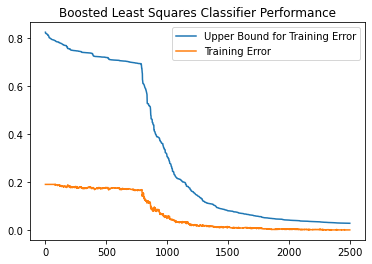

In [13]:
plt.plot(list(performance.keys()), [item[3] for item in list(performance.values())], label = "Upper Bound for Training Error")

plt.plot(list(performance.keys()), [item[0] for item in list(performance.values())], label = "Training Error")
plt.legend()
plt.title("Boosted Least Squares Classifier Performance")
#plt.savefig("adaboost_performance")

<ipython-input-14-61f7040389b6>:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(list(dubs_avg.values()))


Text(0, 0.5, 'Average Weight')

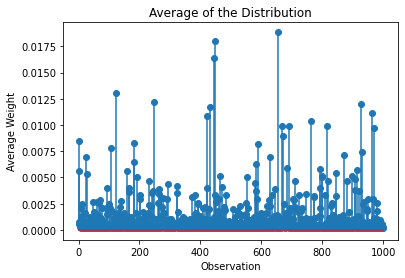

In [14]:
#WHY WOULD AVERAGE WEIGHT EVER CHANGE?
plt.stem(list(dubs_avg.values()))
plt.title("Average of the Distribution")
plt.xlabel("Observation")
plt.ylabel("Average Weight")
# plt.savefig("adaboost_stem")

Text(0.5, 1.0, 'Epsilon Over Time')

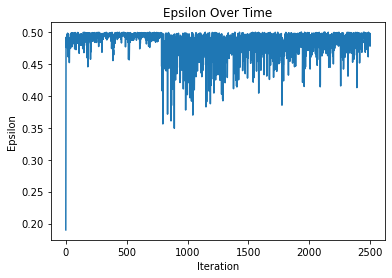

In [15]:
plt.plot(list(performance.keys()), [item[1] for item in list(performance.values())])
plt.ylabel("Epsilon")
plt.xlabel("Iteration")
plt.title("Epsilon Over Time")
# plt.savefig("adaboost_epsilon")

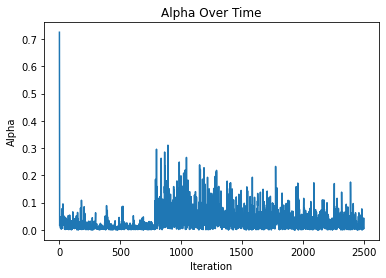

In [16]:
plt.plot(list(performance.keys()), [item[2] for item in list(performance.values())])
plt.ylabel("Alpha")
plt.xlabel("Iteration")
plt.title("Alpha Over Time")
plt.savefig("adaboost_alpha")

PROBLEM 2

In [17]:
mean1 = [0, 0]
cov1 = [[1, 0], [0, 1]]

mean2 = [3, 0]
cov2 = [[1, 0], [0, 1]]

mean3 = [0, 3]
cov3 = [[1, 0], [0, 1]]

In [18]:
x1, y1 = np.random.multivariate_normal(mean1, cov1, 100).T
x2, y2 = np.random.multivariate_normal(mean2, cov2, 250).T
x3, y3 = np.random.multivariate_normal(mean3, cov3, 150).T

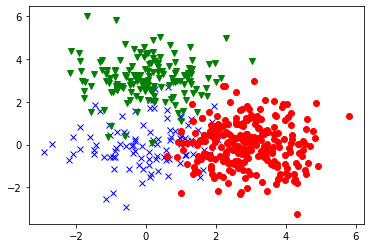

In [19]:
plt.plot(x1, y1, 'bx')
plt.plot(x2, y2, 'ro')
plt.plot(x3, y3, 'gv')

In [20]:
class points_k:
    def __init__(self, coordinates, cluster):
        self.coord = coordinates
        self.clust = cluster
    

In [21]:
p = []
for i in range(len(x1)):
    p.append(points_k(\
                      np.array((x1[i], y1[i])), \
                      None))
for i in range(len(x2)):
    p.append(points_k(\
                      np.array((x2[i], y2[i])), \
                      None))
for i in range(len(x3)):
    p.append(points_k(\
                      np.array((x3[i], y3[i])), \
                      None))


In [22]:
def cent(cluster, points):
    live_in_texas = []
    beyond_your_years = []
    
    for point in points:
        if point.clust == cluster:
            live_in_texas.append(point.coord[0])
            beyond_your_years.append(point.coord[1])
            
    mu = np.array((np.mean(live_in_texas), np.mean(beyond_your_years)))
    return points_k(mu, cluster)

In [23]:
def dist(x, mu):
    return np.linalg.norm(x - mu)

In [24]:
def k_obj(points, centroid):
    
    things_to_sum = []
    
    for point in points:
        if point.clust == centroid.clust:
            larry = dist(point.coord, centroid.coord)
            things_to_sum.append(larry)
    
    return sum(things_to_sum)

In [25]:
def init_clust(points, k):
    for i in points:
        i.clust = random.choice(range(k))
    return points

In [26]:
def mu_update(points, k):
    m = []
    for j in range(k):
        m.append(cent(j, points))
    return m

In [27]:
def c_update(points, centroids):
    for point in points:
        min_dist = 9999999999999999999999999
        for centroid in centroids:
            if dist(point.coord, centroid.coord) < min_dist:
                point.clust = centroid.clust
                min_dist = dist(point.coord, centroid.coord)
    return points

In [28]:
def altogether(points, k):
    #LISTS FOR PLOT LATER
    iteration = []
    obj_func = []
    
    #RANDOM ASSIGNMENT INITIALIZATION
    points_to_use = init_clust(points, 5)
    
    for i in range(20):
        iteration.append(i)
        obj_pieces = []
        
        m = mu_update(points_to_use, k)
        
        points_to_use = c_update(points_to_use, m)
        
        things_to_sum = []
        
        for j in range(k):
            obj_pieces.append(k_obj(points_to_use, m[j]))
        
        obj_func.append(sum(obj_pieces))
    return iteration, obj_func

Text(0, 0.5, 'Objective Function')

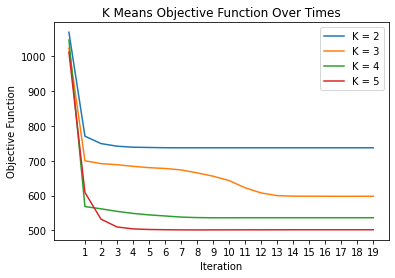

In [29]:
iterations2, outcomes2 = altogether(p, 2)
iterations3, outcomes3 = altogether(p, 3)
iterations4, outcomes4 = altogether(p, 4)
iterations5, outcomes5 = altogether(p, 5)

plt.plot(iterations2, outcomes2, label = "K = 2")
plt.plot(iterations3, outcomes3, label = "K = 3")
plt.plot(iterations4, outcomes4, label = "K = 4")
plt.plot(iterations5, outcomes5, label = "K = 5")
plt.xticks(ticks = np.arange(1, 20))
plt.legend()
plt.title("K Means Objective Function Over Times")
plt.xlabel("Iteration")
plt.ylabel("Objective Function")
# plt.savefig("k_means")

In [30]:
def altogether_pts_plt(points, k):
    #LISTS FOR PLOT LATER
    iteration = []
    obj_func = []
    
    #RANDOM ASSIGNMENT INITIALIZATION
    points_to_use = init_clust(points, 5)
    
    for i in range(20):
        iteration.append(i)
        obj_pieces = []
        
        m = mu_update(points_to_use, k)
        
        points_to_use = c_update(points_to_use, m)
        
        things_to_sum = []
        
        for j in range(k):
            obj_pieces.append(k_obj(points_to_use, m[j]))
        
        obj_func.append(sum(obj_pieces))
    return points_to_use

In [31]:
points_to_plot3 = altogether_pts_plt(p, 3)

In [32]:

#ALL MY Xs
live_in_texas1 = []
live_in_texas2 = []
live_in_texas3 = []
live_in_texas4 = []
live_in_texas5 = []

#YOUR Ys
beyond_your_years1 = []
beyond_your_years2 = []
beyond_your_years3 = []
beyond_your_years4 = []
beyond_your_years5 = []

for point in points_to_plot3:
    if point.clust == 0:
        live_in_texas1.append(point.coord[0])
        beyond_your_years1.append(point.coord[1])
    elif point.clust == 1:
        live_in_texas2.append(point.coord[0])
        beyond_your_years2.append(point.coord[1])
    elif point.clust == 2:
        live_in_texas3.append(point.coord[0])
        beyond_your_years3.append(point.coord[1])
    elif point.clust == 3:
        live_in_texas4.append(point.coord[0])
        beyond_your_years4.append(point.coord[1])
    elif point.clust == 4:
        live_in_texas5.append(point.coord[0])
        beyond_your_years5.append(point.coord[1])

Text(0.5, 1.0, 'Final Clusters - K = 3')

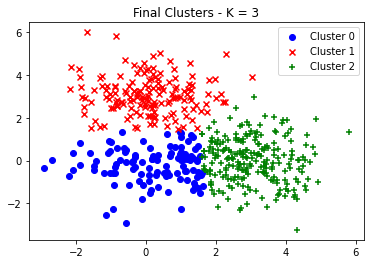

In [33]:
plt.scatter(live_in_texas1, beyond_your_years1, c = 'b', marker = 'o', label = "Cluster 0")
plt.scatter(live_in_texas2, beyond_your_years2, c = 'r', marker = 'x', label = "Cluster 1")
plt.scatter(live_in_texas3, beyond_your_years3, c = 'g', marker = '+', label = "Cluster 2")
# plt.scatter(live_in_texas4, beyond_your_years4, c = 'y', marker = '^', label = "Cluster 3")
# plt.scatter(live_in_texas5, beyond_your_years5, c = 'k', marker = 'v', label = "Cluster 4")
plt.legend()
plt.title("Final Clusters - K = 3")
# plt.savefig("3_clusts")

In [34]:
points_to_plot5 = altogether_pts_plt(p, 5)

In [35]:

#ALL MY Xs
live_in_texas1 = []
live_in_texas2 = []
live_in_texas3 = []
live_in_texas4 = []
live_in_texas5 = []

#YOUR Ys
beyond_your_years1 = []
beyond_your_years2 = []
beyond_your_years3 = []
beyond_your_years4 = []
beyond_your_years5 = []

for point in points_to_plot5:
    if point.clust == 0:
        live_in_texas1.append(point.coord[0])
        beyond_your_years1.append(point.coord[1])
    elif point.clust == 1:
        live_in_texas2.append(point.coord[0])
        beyond_your_years2.append(point.coord[1])
    elif point.clust == 2:
        live_in_texas3.append(point.coord[0])
        beyond_your_years3.append(point.coord[1])
    elif point.clust == 3:
        live_in_texas4.append(point.coord[0])
        beyond_your_years4.append(point.coord[1])
    elif point.clust == 4:
        live_in_texas5.append(point.coord[0])
        beyond_your_years5.append(point.coord[1])

Text(0.5, 1.0, 'Final Clusters - K = 5')

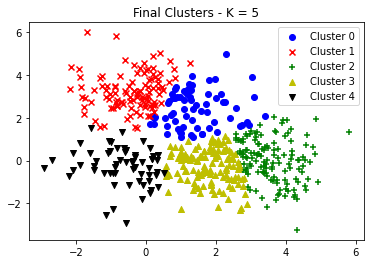

In [36]:
plt.scatter(live_in_texas1, beyond_your_years1, c = 'b', marker = 'o', label = "Cluster 0")
plt.scatter(live_in_texas2, beyond_your_years2, c = 'r', marker = 'x', label = "Cluster 1")
plt.scatter(live_in_texas3, beyond_your_years3, c = 'g', marker = '+', label = "Cluster 2")
plt.scatter(live_in_texas4, beyond_your_years4, c = 'y', marker = '^', label = "Cluster 3")
plt.scatter(live_in_texas5, beyond_your_years5, c = 'k', marker = 'v', label = "Cluster 4")
plt.legend()
plt.title("Final Clusters - K = 5")
# plt.savefig("5_clusts")

PROBLEM 3

In [31]:
ex_test = pd.read_csv("hw3-data/Prob3_Xtest.csv", header = None)
why_test = pd.read_csv("hw3-data/Prob3_ytest.csv", header = None)

ex_train = pd.read_csv("hw3-data/Prob3_Xtrain.csv", header = None)
why_train = pd.read_csv("hw3-data/Prob3_ytrain.csv", header = None)

In [32]:
class_1_pct = sum(why_test[0])/len(why_test)
class_0_pct = 1 - class_1_pct

In [33]:
#TO FOCUS ON ONE AT A TIME
def one_class(num):
    
    why_train_use = why_train[why_train[0] == num].sort_index()
    ex_train_use = ex_train[ex_train.index.isin(why_train_use.index)].sort_index()
    
    why_test_use = why_test[why_test[0] == num].sort_index()
    ex_test_use = ex_test[ex_test.index.isin(why_test_use.index)].sort_index()
    
    return why_train_use, ex_train_use, why_test_use, ex_test_use


In [34]:
def update_phi(k, pdf):
    for i in ex_train_use.index:
        phi[i][k] = (pi_k[k] * pdf[i])/(pi_k[0] * pdf1[i])

In [35]:
def update_phi_2(k, pdf):
    for i in ex_train_use.index:
        phi[i][k] = (pi_k[k] * pdf[i])/(pi_k[0] * pdf1[i]\
                                       +pi_k[1] * pdf2[i])

In [36]:
def update_phi_3(k, pdf):
    for i in ex_train_use.index:
        phi[i][k] = (pi_k[k] * pdf[i])/(pi_k[0] * pdf1[i]\
                                       +pi_k[1] * pdf2[i]\
                                       +pi_k[2] * pdf3[i])

In [37]:
def update_phi_4(k, pdf):
    for i in ex_train_use.index:
        phi[i][k] = (pi_k[k] * pdf[i])/(pi_k[0] * pdf1[i]\
                                       +pi_k[1] * pdf2[i]\
                                       +pi_k[2] * pdf3[i]\
                                       +pi_k[3] * pdf4[i])

In [38]:
def update_mu(k):
    
    mu = np.zeros(10)
    
    for i in ex_train_use.index:
        for j in range(10):
            mu[j] += ex_train_use.loc[i, j] *\
            [item[k] for item in phi.values()][i]
    
    mu = [1/n_k[k] * x for x in mu]
    
    return mu

In [39]:
def update_cov(k):
    larry = []

    for i in ex_train_use.index:

        x_i = np.array(ex_train_use.loc[i])

        diff = np.array(x_i - mu_k[k]).reshape(10, 1)

        guy = phi[i][k] * np.matmul(diff, diff.T)

        larry.append(guy)

    final = sum(larry)
        
    final = 1/n_k[k] * final

    return final

In [40]:
#1 CLASS

why_train_use, ex_train_use, why_test_use, ex_test_use = one_class(1)

cov = np.cov(ex_train_use.T)

mean = np.mean(ex_train_use)



In [41]:
#INITIALIZE 0S/EMPTIES

phi = {}

for i in ex_train_use.index:
    phi[i] = [1/3, 1/3, 1/3]
    
n_k = [0, 0, 0]

pi_k = [1/3, 1/3, 1/3]

mu_k = np.random.multivariate_normal(mean, cov, 3)

cov_k = [cov, cov, cov]

spam_test_probs = {}


In [42]:
runs = {}
for j in range(10):
    #INITIALIZE 0S/EMPTIES

    phi = {}
    test_probs = {}

    for i in ex_train_use.index:
        phi[i] = [1/3, 1/3, 1/3]

    n_k = [0, 0, 0]

    pi_k = [1/3, 1/3, 1/3]

    mu_k = np.random.multivariate_normal(mean, cov, 3)

    cov_k = [cov, cov, cov]

    performance = {}

    for i in range(30):
        #GET 3 PDFS
        pdf1 = stats.multivariate_normal.pdf(ex_train_use, mu_k[0], cov_k[0], allow_singular = True)
        pdf2 = stats.multivariate_normal.pdf(ex_train_use, mu_k[1], cov_k[1], allow_singular = True)
        pdf3 = stats.multivariate_normal.pdf(ex_train_use, mu_k[2], cov_k[2], allow_singular = True)

        #GET PHIs FOR EACH OBS
        update_phi_3(0, pdf1)
        update_phi_3(1, pdf2)
        update_phi_3(2, pdf3)

        #GET EACH N_k
        n_k[0] = sum([item[0] for item in phi.values()])
        n_k[1] = sum([item[1] for item in phi.values()])
        n_k[2] = sum([item[2] for item in phi.values()])

        #UPDATE PIs
        pi_k[0] = n_k[0]/len(ex_train_use)
        pi_k[1] = n_k[1]/len(ex_train_use)
        pi_k[2] = n_k[2]/len(ex_train_use)

        #GET NEW MUs
        mu_1 = update_mu(0)
        mu_2 = update_mu(1)
        mu_3 = update_mu(2)

        mu_k = [mu_1, mu_2, mu_3]

        #AND NEW COVs
        cov_k = [update_cov(0), update_cov(1), update_cov(2)]

        #AND LOSS FUNCTION

        final_sum = []

        for obs in ex_train_use.index:
            to_sum_k = [0, 0, 0]
            to_sum_k[0] += pi_k[0] * pdf1[obs]
            to_sum_k[1] += pi_k[1] * pdf2[obs]
            to_sum_k[2] += pi_k[2] * pdf3[obs]
            summed_k = sum(to_sum_k)
            to_sum = np.log(summed_k)
            final_sum.append(to_sum)

        loss = sum(final_sum)

        performance[i + 1] = loss
        print(j, i, loss)
        
        if i + 1 == 30:
            pdf1_test = stats.multivariate_normal.pdf(ex_test, mu_k[0], cov_k[0], allow_singular = True)
            pdf2_test = stats.multivariate_normal.pdf(ex_test, mu_k[1], cov_k[1], allow_singular = True)
            pdf3_test = stats.multivariate_normal.pdf(ex_test, mu_k[2], cov_k[2], allow_singular = True)
            
            for test_obs in why_test.index:
                test_probs[test_obs] = pi_k[0] * pdf1_test[test_obs] +\
                                            pi_k[1] * pdf2_test[test_obs] +\
                                            pi_k[2] * pdf3_test[test_obs]
            spam_test_probs[j + 1] = test_probs
                
    runs[j + 1] = performance

0 0 22290.943012498286
0 1 38182.32022059619
0 2 42232.5385298072
0 3 43105.122154361954
0 4 44070.54390946715
0 5 44815.468397546196
0 6 45214.54058397153
0 7 45496.24604606201
0 8 45622.00632316782
0 9 45690.047562947664
0 10 45714.66318885604
0 11 45727.13307053431
0 12 45746.37133871447
0 13 45858.19075360198
0 14 45904.568492977894
0 15 45922.897066972335
0 16 45928.96304132287
0 17 45932.38613559818
0 18 45933.878986377655
0 19 45934.49945400756
0 20 45934.7941653543
0 21 45935.09282646042
0 22 45935.848896430085
0 23 45939.22619015231
0 24 45947.539009974505
0 25 45954.237412681505
0 26 45957.42788831296
0 27 45958.31094225935
0 28 45958.514305380064
0 29 45958.57777158845
1 0 21435.695315127705
1 1 38698.7689999554
1 2 45117.620510506145
1 3 45777.16806498194
1 4 45946.254528813144
1 5 45987.16998813865
1 6 46000.99647643277
1 7 46011.93274006726
1 8 46019.10481435785
1 9 46042.352464867916
1 10 46052.138761414004
1 11 46052.31177801261
1 12 46052.33095987248
1 13 46052.3349293

In [43]:
performance1 = runs[1]
performance2 = runs[2]
performance3 = runs[3]
performance4 = runs[4]
performance5 = runs[5]
performance6 = runs[6]
performance7 = runs[7]
performance8 = runs[8]
performance9 = runs[9]
performance10 = runs[10]


In [44]:
to_plot_dict1 = {k: v for k, v in performance1.items() if k > 4}
to_plot_dict2 = {k: v for k, v in performance2.items() if k > 4}
to_plot_dict3 = {k: v for k, v in performance3.items() if k > 4}
to_plot_dict4 = {k: v for k, v in performance4.items() if k > 4}
to_plot_dict5 = {k: v for k, v in performance5.items() if k > 4}
to_plot_dict6 = {k: v for k, v in performance6.items() if k > 4}
to_plot_dict7 = {k: v for k, v in performance7.items() if k > 4}
to_plot_dict8 = {k: v for k, v in performance8.items() if k > 4}
to_plot_dict9 = {k: v for k, v in performance9.items() if k > 4}
to_plot_dict10 = {k: v for k, v in performance10.items() if k > 4}

Text(0.5, 1.0, 'Class = 1 Objective Function')

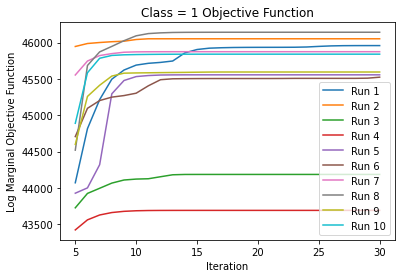

In [45]:
plt.plot(list(to_plot_dict1.keys()), list(to_plot_dict1.values()), label = "Run 1")
plt.plot(list(to_plot_dict2.keys()), list(to_plot_dict2.values()), label = "Run 2")
plt.plot(list(to_plot_dict3.keys()), list(to_plot_dict3.values()), label = "Run 3")
plt.plot(list(to_plot_dict4.keys()), list(to_plot_dict4.values()), label = "Run 4")
plt.plot(list(to_plot_dict5.keys()), list(to_plot_dict5.values()), label = "Run 5")
plt.plot(list(to_plot_dict6.keys()), list(to_plot_dict6.values()), label = "Run 6")
plt.plot(list(to_plot_dict7.keys()), list(to_plot_dict7.values()), label = "Run 7")
plt.plot(list(to_plot_dict8.keys()), list(to_plot_dict8.values()), label = "Run 8")
plt.plot(list(to_plot_dict9.keys()), list(to_plot_dict9.values()), label = "Run 9")
plt.plot(list(to_plot_dict10.keys()), list(to_plot_dict10.values()), label = "Run 10")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Log Marginal Objective Function")
plt.title("Class = 1 Objective Function")
# plt.savefig("class_1_obj_funct")

In [46]:
best = to_plot_dict1

if to_plot_dict2[30] > to_plot_dict1[30]:
    best = to_plot_dict2
if to_plot_dict3[30] > best[30]:
    best =to_plot_dict3
if to_plot_dict4[30] > best[30]:
    best =to_plot_dict4
if to_plot_dict5[30] > best[30]:
    best =to_plot_dict5
if to_plot_dict6[30] > best[30]:
    best =to_plot_dict6
if to_plot_dict7[30] > best[30]:
    best =to_plot_dict7
if to_plot_dict8[30] > best[30]:
    best =to_plot_dict8
if to_plot_dict9[30] > best[30]:
    best =to_plot_dict9
if to_plot_dict10[30] > best[30]:
    best =to_plot_dict10
    
if best == to_plot_dict1:
    use = 1
elif best == to_plot_dict2:
    use = 2
elif best == to_plot_dict3:
    use = 3
elif best == to_plot_dict4:
    use = 4
elif best == to_plot_dict5:
    use = 5
elif best == to_plot_dict6:
    use = 6
elif best == to_plot_dict7:
    use = 7
elif best == to_plot_dict8:
    use = 8
elif best == to_plot_dict9:
    use = 9
elif best == to_plot_dict10:
    use = 10

spam_probs_use = spam_test_probs[use]

In [47]:
spam_probs_use

{0: 676717882659883.8,
 1: 157394717363.86267,
 2: 392504309118445.7,
 3: 189789810099.77475,
 4: 1135943850491817.0,
 5: 51279.03525274703,
 6: 245627851028647.56,
 7: 15065000368.55754,
 8: 11031061488905.795,
 9: 272676006248.79782,
 10: 36841154152.655815,
 11: 257120411652.1238,
 12: 5313721727.172968,
 13: 640689388465.7008,
 14: 1553620489972402.5,
 15: 312609498676175.56,
 16: 28106.14985151427,
 17: 1325005793139.846,
 18: 17406591.852133863,
 19: 7573674629.897771,
 20: 622039932480.2805,
 21: 544331991272990.1,
 22: 148395215855528.66,
 23: 249617111990.28348,
 24: 52819584054653.055,
 25: 2.1887790266851597e-09,
 26: 662660678502840.4,
 27: 3191720776849082.5,
 28: 150998127.36647463,
 29: 680157604.1426339,
 30: 29842427706861.703,
 31: 96781059678001.33,
 32: 506382926431657.4,
 33: 44110497451.7594,
 34: 506382926431657.4,
 35: 1937625.8426764496,
 36: 38540444183.522736,
 37: 635328968041990.0,
 38: 4680739846511.769,
 39: 838178539103843.4,
 40: 884156067232749.6,
 41:

AGAIN BUT FOR CLASS = 0

In [48]:
#1 CLASS

why_train_use, ex_train_use, why_test_use, ex_test_use = one_class(0)

why_train_use = why_train_use.reset_index(drop = True)
ex_train_use = ex_train_use.reset_index(drop = True)
why_test_use = why_test_use.reset_index(drop = True)
ex_test_use = ex_test_use.reset_index(drop = True)

cov = np.cov(ex_train_use.T)

mean = np.mean(ex_train_use)



In [49]:
#INITIALIZE 0S/EMPTIES

phi = {}

for i in ex_train_use.index:
    phi[i] = [1/3, 1/3, 1/3]
    
n_k = [0, 0, 0]

pi_k = [1/3, 1/3, 1/3]

mu_k = np.random.multivariate_normal(mean, cov, 3)

cov_k = [cov, cov, cov]

no_spam_test_probs = {}


In [50]:
runs = {}
for j in range(10):
    #INITIALIZE 0S/EMPTIES

    phi = {}
    test_probs = {}

    for i in ex_train_use.index:
        phi[i] = [1/3, 1/3, 1/3]

    n_k = [0, 0, 0]

    pi_k = [1/3, 1/3, 1/3]

    mu_k = np.random.multivariate_normal(mean, cov, 3)

    cov_k = [cov, cov, cov]

    performance = {}

    for i in range(30):
        #GET 3 PDFS
        pdf1 = stats.multivariate_normal.pdf(ex_train_use, mu_k[0], cov_k[0], allow_singular = True)
        pdf2 = stats.multivariate_normal.pdf(ex_train_use, mu_k[1], cov_k[1], allow_singular = True)
        pdf3 = stats.multivariate_normal.pdf(ex_train_use, mu_k[2], cov_k[2], allow_singular = True)

        #GET PHIs FOR EACH OBS
        update_phi_3(0, pdf1)
        update_phi_3(1, pdf2)
        update_phi_3(2, pdf3)

        #GET EACH N_k
        n_k[0] = sum([item[0] for item in phi.values()])
        n_k[1] = sum([item[1] for item in phi.values()])
        n_k[2] = sum([item[2] for item in phi.values()])

        #UPDATE PIs
        pi_k[0] = n_k[0]/len(ex_train_use)
        pi_k[1] = n_k[1]/len(ex_train_use)
        pi_k[2] = n_k[2]/len(ex_train_use)

        #GET NEW MUs
        mu_1 = update_mu(0)
        mu_2 = update_mu(1)
        mu_3 = update_mu(2)

        mu_k = [mu_1, mu_2, mu_3]

        #AND NEW COVs
        cov_k = [update_cov(0), update_cov(1), update_cov(2)]

        #AND LOSS FUNCTION

        final_sum = []

        for obs in ex_train_use.index:
            to_sum_k = [0, 0, 0]
            to_sum_k[0] += pi_k[0] * pdf1[obs]
            to_sum_k[1] += pi_k[1] * pdf2[obs]
            to_sum_k[2] += pi_k[2] * pdf3[obs]
            summed_k = sum(to_sum_k)
            to_sum = np.log(summed_k)
            final_sum.append(to_sum)

        loss = sum(final_sum)

        performance[i + 1] = loss
        print(j, i, loss)
        
        if i + 1 == 30:
            pdf1_test = stats.multivariate_normal.pdf(ex_test, mu_k[0], cov_k[0], allow_singular = True)
            pdf2_test = stats.multivariate_normal.pdf(ex_test, mu_k[1], cov_k[1], allow_singular = True)
            pdf3_test = stats.multivariate_normal.pdf(ex_test, mu_k[2], cov_k[2], allow_singular = True)
            
            for test_obs in why_test.index:
                test_probs[test_obs] = pi_k[0] * pdf1_test[test_obs] +\
                                            pi_k[1] * pdf2_test[test_obs] +\
                                            pi_k[2] * pdf3_test[test_obs]
            no_spam_test_probs[j + 1] = test_probs
    runs[j + 1] = performance

0 0 17411.92573025865
0 1 39318.89031895058
0 2 42197.55802037923
0 3 43378.694850640124
0 4 43890.06628248901
0 5 44148.60455476179
0 6 44423.6409656633
0 7 44584.86824006331
0 8 44686.42132085249
0 9 44806.3295714133
0 10 44882.5195232661
0 11 44930.37524545376
0 12 44970.50930712518
0 13 44996.876190560375
0 14 45015.83076890828
0 15 45035.98935234909
0 16 45060.14268189767
0 17 45096.87949949951
0 18 45167.754397834346
0 19 45297.00664244836
0 20 45471.055982905316
0 21 45572.410465939334
0 22 45628.28489755074
0 23 45641.426354772666
0 24 45645.02376238564
0 25 45646.68721346454
0 26 45647.711074785584
0 27 45650.325202017295
0 28 45660.843275386265
0 29 45670.384912841175
1 0 13413.902950881287
1 1 38582.970804179306
1 2 42244.86821109979
1 3 43428.78338908932
1 4 43950.83119490243
1 5 44206.7103750942
1 6 44416.2394601638
1 7 44564.318356979114
1 8 44673.01559548801
1 9 44751.33498962157
1 10 44811.72462357321
1 11 44868.575737880674
1 12 44887.66476784708
1 13 44907.5574549984


In [51]:
performance1 = runs[1]
performance2 = runs[2]
performance3 = runs[3]
performance4 = runs[4]
performance5 = runs[5]
performance6 = runs[6]
performance7 = runs[7]
performance8 = runs[8]
performance9 = runs[9]
performance10 = runs[10]


In [52]:
to_plot_dict1 = {k: v for k, v in performance1.items() if k > 4}
to_plot_dict2 = {k: v for k, v in performance2.items() if k > 4}
to_plot_dict3 = {k: v for k, v in performance3.items() if k > 4}
to_plot_dict4 = {k: v for k, v in performance4.items() if k > 4}
to_plot_dict5 = {k: v for k, v in performance5.items() if k > 4}
to_plot_dict6 = {k: v for k, v in performance6.items() if k > 4}
to_plot_dict7 = {k: v for k, v in performance7.items() if k > 4}
to_plot_dict8 = {k: v for k, v in performance8.items() if k > 4}
to_plot_dict9 = {k: v for k, v in performance9.items() if k > 4}
to_plot_dict10 = {k: v for k, v in performance10.items() if k > 4}

Text(0.5, 1.0, 'Class = 0 Objective Function')

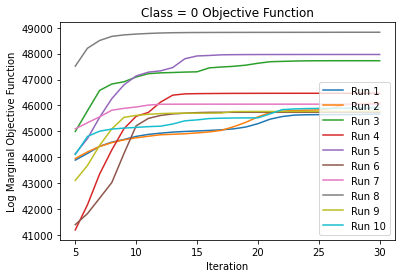

In [53]:
plt.plot(list(to_plot_dict1.keys()), list(to_plot_dict1.values()), label = "Run 1")
plt.plot(list(to_plot_dict2.keys()), list(to_plot_dict2.values()), label = "Run 2")
plt.plot(list(to_plot_dict3.keys()), list(to_plot_dict3.values()), label = "Run 3")
plt.plot(list(to_plot_dict4.keys()), list(to_plot_dict4.values()), label = "Run 4")
plt.plot(list(to_plot_dict5.keys()), list(to_plot_dict5.values()), label = "Run 5")
plt.plot(list(to_plot_dict6.keys()), list(to_plot_dict6.values()), label = "Run 6")
plt.plot(list(to_plot_dict7.keys()), list(to_plot_dict7.values()), label = "Run 7")
plt.plot(list(to_plot_dict8.keys()), list(to_plot_dict8.values()), label = "Run 8")
plt.plot(list(to_plot_dict9.keys()), list(to_plot_dict9.values()), label = "Run 9")
plt.plot(list(to_plot_dict10.keys()), list(to_plot_dict10.values()), label = "Run 10")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Log Marginal Objective Function")
plt.title("Class = 0 Objective Function")
# plt.savefig("class_0_obj_funct")

In [54]:
best = to_plot_dict1

if to_plot_dict2[30] > to_plot_dict1[30]:
    best = to_plot_dict2
if to_plot_dict3[30] > best[30]:
    best =to_plot_dict3
if to_plot_dict4[30] > best[30]:
    best =to_plot_dict4
if to_plot_dict5[30] > best[30]:
    best =to_plot_dict5
if to_plot_dict6[30] > best[30]:
    best =to_plot_dict6
if to_plot_dict7[30] > best[30]:
    best =to_plot_dict7
if to_plot_dict8[30] > best[30]:
    best =to_plot_dict8
if to_plot_dict9[30] > best[30]:
    best =to_plot_dict9
if to_plot_dict10[30] > best[30]:
    best =to_plot_dict10
    
if best == to_plot_dict1:
    use = 1
elif best == to_plot_dict2:
    use = 2
elif best == to_plot_dict3:
    use = 3
elif best == to_plot_dict4:
    use = 4
elif best == to_plot_dict5:
    use = 5
elif best == to_plot_dict6:
    use = 6
elif best == to_plot_dict7:
    use = 7
elif best == to_plot_dict8:
    use = 8
elif best == to_plot_dict9:
    use = 9
elif best == to_plot_dict10:
    use = 10

no_spam_probs_use = no_spam_test_probs[use]
no_spam_probs_use

{0: 475781.97580074985,
 1: 4380104.951169235,
 2: 2815196251590.0986,
 3: 91624623.90097556,
 4: 46583355.43015947,
 5: 15.809482495965266,
 6: 122854.86195700643,
 7: 17744.04825407578,
 8: 196635128.6882886,
 9: 2719.1886355239176,
 10: 99951.32343202502,
 11: 459761.99931698845,
 12: 721456.4548325961,
 13: 16185007.431966908,
 14: 31519176.222098663,
 15: 30917511.058484692,
 16: 3640.666640221367,
 17: 278834671.6835874,
 18: 564228.3115224899,
 19: 3.2584884489723396,
 20: 1552.6296022294862,
 21: 564974.6520669481,
 22: 31147794.141404364,
 23: 28203294.740062714,
 24: 4607032.064159691,
 25: 3343929584.9892607,
 26: 11609881.739098448,
 27: 5203688.926380747,
 28: 17.84813721741918,
 29: 650.7629315489924,
 30: 94821.69850876609,
 31: 840467148.9909642,
 32: 13346653.670730816,
 33: 30691910.287461594,
 34: 13346653.670730816,
 35: 314539.83365057135,
 36: 164235.12283874367,
 37: 98319503742.50742,
 38: 2386170.3293404463,
 39: 31874360.73427791,
 40: 17342878.5140329,
 41: 6

In [55]:
preds = []
was_1_pred_1 = 0
was_1_pred_0 = 0
was_0_pred_1 = 0
was_0_pred_0 = 0
for i in range(len(why_test)):
    if class_1_pct * spam_probs_use[i] > class_0_pct * no_spam_probs_use[i]:
        preds.append(1)
    else:
        preds.append(0)
    if why_test.loc[i, 0] == 1 and preds[i] == 1:
        was_1_pred_1 += 1
    elif why_test.loc[i, 0] == 1 and preds[i] == 0:
        was_1_pred_0 += 1
    elif why_test.loc[i, 0] == 0 and preds[i] == 1:
        was_0_pred_1 += 1
    elif why_test.loc[i, 0] == 0 and preds[i] == 0:
        was_0_pred_0 += 1

In [56]:
[[was_1_pred_1, was_1_pred_0], [was_0_pred_1, was_0_pred_0]]

[[174, 8], [94, 184]]

In [57]:
(was_1_pred_1 + was_0_pred_0)/(was_1_pred_1 + was_1_pred_0 + was_0_pred_1 + was_0_pred_0)

0.7782608695652173

In [58]:
gmm3_cm = metrics.confusion_matrix(np.array(why_test), preds)

In [59]:
gmm3_cm

array([[184,  94],
       [  8, 174]])

2 GMM NOW

In [60]:
#1 CLASS

why_train_use, ex_train_use, why_test_use, ex_test_use = one_class(1)

cov = np.cov(ex_train_use.T)

mean = np.mean(ex_train_use)



In [61]:
#INITIALIZE 0S/EMPTIES

phi = {}

for i in ex_train_use.index:
    phi[i] = [1/3, 1/3, 1/3]
    
n_k = [0, 0, 0]

pi_k = [1/3, 1/3, 1/3]

mu_k = np.random.multivariate_normal(mean, cov, 2)

cov_k = [cov, cov, cov]

spam_test_probs = {}


In [62]:
runs = {}
for j in range(10):
    #INITIALIZE 0S/EMPTIES

    phi = {}
    test_probs = {}

    for i in ex_train_use.index:
        phi[i] = [1/2, 1/2]

    n_k = [0, 0]

    pi_k = [1/2, 1/2]

    mu_k = np.random.multivariate_normal(mean, cov, 2)

    cov_k = [cov, cov]

    performance = {}

    for i in range(30):
        #GET 3 PDFS
        pdf1 = stats.multivariate_normal.pdf(ex_train_use, mu_k[0], cov_k[0], allow_singular = True)
        pdf2 = stats.multivariate_normal.pdf(ex_train_use, mu_k[1], cov_k[1], allow_singular = True)

        #GET PHIs FOR EACH OBS
        update_phi_2(0, pdf1)
        update_phi_2(1, pdf2)

        #GET EACH N_k
        n_k[0] = sum([item[0] for item in phi.values()])
        n_k[1] = sum([item[1] for item in phi.values()])

        #UPDATE PIs
        pi_k[0] = n_k[0]/len(ex_train_use)
        pi_k[1] = n_k[1]/len(ex_train_use)

        #GET NEW MUs
        mu_1 = update_mu(0)
        mu_2 = update_mu(1)

        mu_k = [mu_1, mu_2]

        #AND NEW COVs
        cov_k = [update_cov(0), update_cov(1)]

        #AND LOSS FUNCTION

        final_sum = []

        for obs in ex_train_use.index:
            to_sum_k = [0, 0, 0]
            to_sum_k[0] += pi_k[0] * pdf1[obs]
            to_sum_k[1] += pi_k[1] * pdf2[obs]
            summed_k = sum(to_sum_k)
            to_sum = np.log(summed_k)
            final_sum.append(to_sum)

        loss = sum(final_sum)

        performance[i + 1] = loss
        print(j, i, loss)
        
        if i + 1 == 30:
            pdf1_test = stats.multivariate_normal.pdf(ex_test, mu_k[0], cov_k[0], allow_singular = True)
            pdf2_test = stats.multivariate_normal.pdf(ex_test, mu_k[1], cov_k[1], allow_singular = True)
            
            for test_obs in why_test.index:
                test_probs[test_obs] = pi_k[0] * pdf1_test[test_obs] +\
                                            pi_k[1] * pdf2_test[test_obs]
            spam_test_probs[j + 1] = test_probs
                
    runs[j + 1] = performance

0 0 21411.20293468352
0 1 34737.13042614849
0 2 39341.300015821784
0 3 41356.27492117352
0 4 41738.47441329256
0 5 41850.153598348705
0 6 42514.95415535408
0 7 42693.66099845089
0 8 42701.99632119104
0 9 42704.645160899905
0 10 42706.42307055223
0 11 42708.14647041655
0 12 42709.87614691882
0 13 42711.2756029902
0 14 42711.99631688435
0 15 42712.199666510256
0 16 42712.237673571406
0 17 42712.2440553574
0 18 42712.245222182464
0 19 42712.245481943275
0 20 42712.24555387016
0 21 42712.24557713506
0 22 42712.24558529775
0 23 42712.2455882667
0 24 42712.245589362676
0 25 42712.24558977004
0 26 42712.24558992156
0 27 42712.245589978134
0 28 42712.24558999924
0 29 42712.245590007304
1 0 21210.87723622509
1 1 33494.42398080866
1 2 36620.82525943483
1 3 37335.69236486304
1 4 37873.59058712989
1 5 38182.88201477533
1 6 38201.22807744617
1 7 38205.83450851631
1 8 38210.34578641316
1 9 38215.21839156731
1 10 38217.18977225551
1 11 38217.70526611663
1 12 38217.8678770521
1 13 38217.9164167659
1 1

In [63]:
performance1 = runs[1]
performance2 = runs[2]
performance3 = runs[3]
performance4 = runs[4]
performance5 = runs[5]
performance6 = runs[6]
performance7 = runs[7]
performance8 = runs[8]
performance9 = runs[9]
performance10 = runs[10]


In [64]:
to_plot_dict1 = {k: v for k, v in performance1.items() if k > 4}
to_plot_dict2 = {k: v for k, v in performance2.items() if k > 4}
to_plot_dict3 = {k: v for k, v in performance3.items() if k > 4}
to_plot_dict4 = {k: v for k, v in performance4.items() if k > 4}
to_plot_dict5 = {k: v for k, v in performance5.items() if k > 4}
to_plot_dict6 = {k: v for k, v in performance6.items() if k > 4}
to_plot_dict7 = {k: v for k, v in performance7.items() if k > 4}
to_plot_dict8 = {k: v for k, v in performance8.items() if k > 4}
to_plot_dict9 = {k: v for k, v in performance9.items() if k > 4}
to_plot_dict10 = {k: v for k, v in performance10.items() if k > 4}

Text(0.5, 1.0, 'Class = 1 Objective Function')

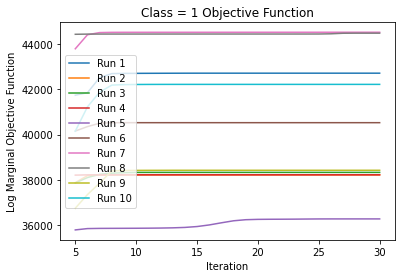

In [65]:
plt.plot(list(to_plot_dict1.keys()), list(to_plot_dict1.values()), label = "Run 1")
plt.plot(list(to_plot_dict2.keys()), list(to_plot_dict2.values()), label = "Run 2")
plt.plot(list(to_plot_dict3.keys()), list(to_plot_dict3.values()), label = "Run 3")
plt.plot(list(to_plot_dict4.keys()), list(to_plot_dict4.values()), label = "Run 4")
plt.plot(list(to_plot_dict5.keys()), list(to_plot_dict5.values()), label = "Run 5")
plt.plot(list(to_plot_dict6.keys()), list(to_plot_dict6.values()), label = "Run 6")
plt.plot(list(to_plot_dict7.keys()), list(to_plot_dict7.values()), label = "Run 7")
plt.plot(list(to_plot_dict8.keys()), list(to_plot_dict8.values()), label = "Run 8")
plt.plot(list(to_plot_dict9.keys()), list(to_plot_dict9.values()), label = "Run 9")
plt.plot(list(to_plot_dict10.keys()), list(to_plot_dict10.values()), label = "Run 10")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Log Marginal Objective Function")
plt.title("Class = 1 Objective Function")
# plt.savefig("class_1_obj_funct")

In [66]:
best = to_plot_dict1

if to_plot_dict2[30] > to_plot_dict1[30]:
    best = to_plot_dict2
if to_plot_dict3[30] > best[30]:
    best =to_plot_dict3
if to_plot_dict4[30] > best[30]:
    best =to_plot_dict4
if to_plot_dict5[30] > best[30]:
    best =to_plot_dict5
if to_plot_dict6[30] > best[30]:
    best =to_plot_dict6
if to_plot_dict7[30] > best[30]:
    best =to_plot_dict7
if to_plot_dict8[30] > best[30]:
    best =to_plot_dict8
if to_plot_dict9[30] > best[30]:
    best =to_plot_dict9
if to_plot_dict10[30] > best[30]:
    best =to_plot_dict10
    
if best == to_plot_dict1:
    use = 1
elif best == to_plot_dict2:
    use = 2
elif best == to_plot_dict3:
    use = 3
elif best == to_plot_dict4:
    use = 4
elif best == to_plot_dict5:
    use = 5
elif best == to_plot_dict6:
    use = 6
elif best == to_plot_dict7:
    use = 7
elif best == to_plot_dict8:
    use = 8
elif best == to_plot_dict9:
    use = 9
elif best == to_plot_dict10:
    use = 10

spam_probs_use = spam_test_probs[use]
spam_probs_use

{0: 281680855712944.25,
 1: 732853055216.5795,
 2: 138633559130212.52,
 3: 334108339044.3285,
 4: 246831804080882.25,
 5: 19682672.92950457,
 6: 112165371138000.64,
 7: 33949031522.988342,
 8: 5367922314608.678,
 9: 2007459479519.1433,
 10: 13230270171.397617,
 11: 145132708235.70816,
 12: 2246133047.510107,
 13: 5707588626700.996,
 14: 440803697389208.1,
 15: 92294605149856.34,
 16: 715696.4461518563,
 17: 15945126708265.922,
 18: 1268692.9672458766,
 19: 56953873989.442154,
 20: 3479251872817.176,
 21: 244349583319772.9,
 22: 123124754216701.16,
 23: 1015503.425677676,
 24: 39670640794783.445,
 25: 5.451456453150039e-09,
 26: 249936351311521.1,
 27: 701945376837456.4,
 28: 1972539600.3669052,
 29: 402584.52531838056,
 30: 20152861551543.152,
 31: 257496700991917.2,
 32: 193707897735578.2,
 33: 1425323274.8640199,
 34: 193707897735578.2,
 35: 934173.9410696154,
 36: 169682.29032696658,
 37: 160238889498893.66,
 38: 3160590880984.7095,
 39: 296272477930210.9,
 40: 229579098008063.5,
 4

AGAIN BUT FOR CLASS = 0

In [67]:
#1 CLASS

why_train_use, ex_train_use, why_test_use, ex_test_use = one_class(0)

why_train_use = why_train_use.reset_index(drop = True)
ex_train_use = ex_train_use.reset_index(drop = True)
why_test_use = why_test_use.reset_index(drop = True)
ex_test_use = ex_test_use.reset_index(drop = True)

cov = np.cov(ex_train_use.T)

mean = np.mean(ex_train_use)



In [68]:
#INITIALIZE 0S/EMPTIES

phi = {}

for i in ex_train_use.index:
    phi[i] = [1/2, 1/2]
    
n_k = [0, 0]

pi_k = [1/2, 1/2]

mu_k = np.random.multivariate_normal(mean, cov, 2)

cov_k = [cov, cov]

no_spam_test_probs = {}


In [69]:
runs_0 = {}
for j in range(10):
    #INITIALIZE 0S/EMPTIES

    phi = {}
    test_probs = {}

    for i in ex_train_use.index:
        phi[i] = [1/2, 1/2]

    n_k = [0, 0]

    pi_k = [1/2, 1/2]

    mu_k = np.random.multivariate_normal(mean, cov, 2)

    cov_k = [cov, cov]

    performance = {}

    for i in range(30):
        #GET 3 PDFS
        pdf1 = stats.multivariate_normal.pdf(ex_train_use, mu_k[0], cov_k[0], allow_singular = True)
        pdf2 = stats.multivariate_normal.pdf(ex_train_use, mu_k[1], cov_k[1], allow_singular = True)

        #GET PHIs FOR EACH OBS
        update_phi_2(0, pdf1)
        update_phi_2(1, pdf2)

        #GET EACH N_k
        n_k[0] = sum([item[0] for item in phi.values()])
        n_k[1] = sum([item[1] for item in phi.values()])

        #UPDATE PIs
        pi_k[0] = n_k[0]/len(ex_train_use)
        pi_k[1] = n_k[1]/len(ex_train_use)

        #GET NEW MUs
        mu_1 = update_mu(0)
        mu_2 = update_mu(1)

        mu_k = [mu_1, mu_2]

        #AND NEW COVs
        cov_k = [update_cov(0), update_cov(1)]

        #AND LOSS FUNCTION

        final_sum = []

        for obs in ex_train_use.index:
            to_sum_k = [0, 0, 0]
            to_sum_k[0] += pi_k[0] * pdf1[obs]
            to_sum_k[1] += pi_k[1] * pdf2[obs]
            summed_k = sum(to_sum_k)
            to_sum = np.log(summed_k)
            final_sum.append(to_sum)

        loss = sum(final_sum)

        performance[i + 1] = loss
        print(j, i, loss)
        
        if i + 1 == 30:
            pdf1_test = stats.multivariate_normal.pdf(ex_test, mu_k[0], cov_k[0], allow_singular = True)
            pdf2_test = stats.multivariate_normal.pdf(ex_test, mu_k[1], cov_k[1], allow_singular = True)
            
            for test_obs in why_test.index:
                test_probs[test_obs] = pi_k[0] * pdf1_test[test_obs] +\
                                            pi_k[1] * pdf2_test[test_obs] 
            no_spam_test_probs[j + 1] = test_probs
    runs_0[j + 1] = performance

0 0 15423.532510989406
0 1 35234.871227953976
0 2 38594.555751896434
0 3 39963.22461208401
0 4 41044.73508214965
0 5 41818.01603080026
0 6 42206.67289299334
0 7 42417.2531790179
0 8 42461.89281640704
0 9 42476.89642725719
0 10 42483.476027745375
0 11 42485.63834845202
0 12 42487.27560040342
0 13 42488.63373689949
0 14 42489.66935083858
0 15 42490.34866024041
0 16 42490.73663614588
0 17 42490.93914084777
0 18 42491.03997544539
0 19 42491.089090167836
0 20 42491.11277713671
0 21 42491.12415018796
0 22 42491.12959976775
0 23 42491.132208507566
0 24 42491.13345671442
0 25 42491.1340537844
0 26 42491.13433934053
0 27 42491.13447589634
0 28 42491.13454119357
0 29 42491.134572414805
1 0 12254.863342282357
1 1 35753.0579332864
1 2 38749.69234663374
1 3 39746.1404528306
1 4 40193.80401326487
1 5 40496.074458020084
1 6 40644.38840874347
1 7 40658.40831875533
1 8 40661.45099150992
1 9 40662.04777413772
1 10 40662.19738113325
1 11 40662.23669586548
1 12 40662.247331546234
1 13 40662.25026433791
1 

In [70]:
performance1_0 = runs_0[1]
performance2_0 = runs_0[2]
performance3_0 = runs_0[3]
performance4_0 = runs_0[4]
performance5_0 = runs_0[5]
performance6_0 = runs_0[6]
performance7_0 = runs_0[7]
performance8_0 = runs_0[8]
performance9_0 = runs_0[9]
performance10_0 = runs_0[10]


In [71]:
to_plot_dict1_0 = {k: v for k, v in performance1_0.items() if k > 4}
to_plot_dict2_0 = {k: v for k, v in performance2_0.items() if k > 4}
to_plot_dict3_0 = {k: v for k, v in performance3_0.items() if k > 4}
to_plot_dict4_0 = {k: v for k, v in performance4_0.items() if k > 4}
to_plot_dict5_0 = {k: v for k, v in performance5_0.items() if k > 4}
to_plot_dict6_0 = {k: v for k, v in performance6_0.items() if k > 4}
to_plot_dict7_0 = {k: v for k, v in performance7_0.items() if k > 4}
to_plot_dict8_0 = {k: v for k, v in performance8_0.items() if k > 4}
to_plot_dict9_0 = {k: v for k, v in performance9_0.items() if k > 4}
to_plot_dict10_0 = {k: v for k, v in performance10_0.items() if k > 4}

Text(0.5, 1.0, 'Class = 0 Objective Function')

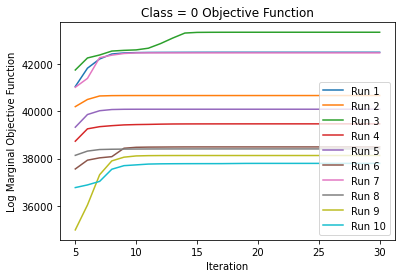

In [72]:
plt.plot(list(to_plot_dict1_0.keys()), list(to_plot_dict1_0.values()), label = "Run 1")
plt.plot(list(to_plot_dict2_0.keys()), list(to_plot_dict2_0.values()), label = "Run 2")
plt.plot(list(to_plot_dict3_0.keys()), list(to_plot_dict3_0.values()), label = "Run 3")
plt.plot(list(to_plot_dict4_0.keys()), list(to_plot_dict4_0.values()), label = "Run 4")
plt.plot(list(to_plot_dict5_0.keys()), list(to_plot_dict5_0.values()), label = "Run 5")
plt.plot(list(to_plot_dict6_0.keys()), list(to_plot_dict6_0.values()), label = "Run 6")
plt.plot(list(to_plot_dict7_0.keys()), list(to_plot_dict7_0.values()), label = "Run 7")
plt.plot(list(to_plot_dict8_0.keys()), list(to_plot_dict8_0.values()), label = "Run 8")
plt.plot(list(to_plot_dict9_0.keys()), list(to_plot_dict9_0.values()), label = "Run 9")
plt.plot(list(to_plot_dict10_0.keys()), list(to_plot_dict10_0.values()), label = "Run 10")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Log Marginal Objective Function")
plt.title("Class = 0 Objective Function")
# plt.savefig("class_0_obj_funct")

In [73]:
best = to_plot_dict1_0

if to_plot_dict2_0[30] > to_plot_dict1_0[30]:
    best = to_plot_dict2_0
if to_plot_dict3_0[30] > best[30]:
    best =to_plot_dict3_0
if to_plot_dict4_0[30] > best[30]:
    best =to_plot_dict4_0
if to_plot_dict5_0[30] > best[30]:
    best =to_plot_dict5_0
if to_plot_dict6_0[30] > best[30]:
    best =to_plot_dict6_0
if to_plot_dict7_0[30] > best[30]:
    best =to_plot_dict7_0
if to_plot_dict8_0[30] > best[30]:
    best =to_plot_dict8_0
if to_plot_dict9_0[30] > best[30]:
    best =to_plot_dict9_0
if to_plot_dict10_0[30] > best[30]:
    best =to_plot_dict10_0
    
if best == to_plot_dict1_0:
    use = 1
elif best == to_plot_dict2_0:
    use = 2
elif best == to_plot_dict3_0:
    use = 3
elif best == to_plot_dict4_0:
    use = 4
elif best == to_plot_dict5_0:
    use = 5
elif best == to_plot_dict6_0:
    use = 6
elif best == to_plot_dict7_0:
    use = 7
elif best == to_plot_dict8_0:
    use = 8
elif best == to_plot_dict9_0:
    use = 9
elif best == to_plot_dict10_0:
    use = 10

no_spam_probs_use = no_spam_test_probs[use]
no_spam_probs_use

{0: 2594.520340659209,
 1: 24083.620732568117,
 2: 24084796600.453518,
 3: 6112813277.73858,
 4: 196661660.4251857,
 5: 871.449907235142,
 6: 1721.9904265922494,
 7: 288.8287015859157,
 8: 192285175.8123601,
 9: 1187.2967723791144,
 10: 354.9249384873806,
 11: 1028.8317228350124,
 12: 2155.25200478647,
 13: 1362932.3764754427,
 14: 48454761.150565594,
 15: 5422473.326263122,
 16: 0.450789122650452,
 17: 3746827193.158205,
 18: 1997.592951780174,
 19: 984.0312082968774,
 20: 1301.597139568124,
 21: 2011.7094297604913,
 22: 41291049.31013139,
 23: 54253989.58991878,
 24: 72804.81595511944,
 25: 491980766.7176799,
 26: 137887.62062049526,
 27: 108940.53661031136,
 28: 1573.4547882136824,
 29: 587.2151895732771,
 30: 483.5171724412366,
 31: 1913360575.262908,
 32: 449234.15803047066,
 33: 106802109.33944005,
 34: 449234.15803047066,
 35: 2427.3580264334705,
 36: 1134.979581792355,
 37: 20651929508.706448,
 38: 5122.317713383181,
 39: 821309611.6217307,
 40: 3463742.295433791,
 41: 2448.871

In [74]:
preds = []
was_1_pred_1 = 0
was_1_pred_0 = 0
was_0_pred_1 = 0
was_0_pred_0 = 0
for i in range(len(why_test)):
    if class_1_pct * spam_probs_use[i] > class_0_pct * no_spam_probs_use[i]:
        preds.append(1)
    else:
        preds.append(0)
    if why_test.loc[i, 0] == 1 and preds[i] == 1:
        was_1_pred_1 += 1
    elif why_test.loc[i, 0] == 1 and preds[i] == 0:
        was_1_pred_0 += 1
    elif why_test.loc[i, 0] == 0 and preds[i] == 1:
        was_0_pred_1 += 1
    elif why_test.loc[i, 0] == 0 and preds[i] == 0:
        was_0_pred_0 += 1

In [75]:
[[was_1_pred_1, was_1_pred_0], [was_0_pred_1, was_0_pred_0]]

[[175, 7], [85, 193]]

In [76]:
(was_1_pred_1 + was_0_pred_0)/(was_1_pred_1 + was_1_pred_0 + was_0_pred_1 + was_0_pred_0)

0.8

In [77]:
gmm2_cm = metrics.confusion_matrix(np.array(why_test), preds)

In [78]:
gmm2_cm

array([[193,  85],
       [  7, 175]])

4 GMM NOW

In [79]:
#1 CLASS

why_train_use, ex_train_use, why_test_use, ex_test_use = one_class(1)

cov = np.cov(ex_train_use.T)

mean = np.mean(ex_train_use)



In [80]:
#INITIALIZE 0S/EMPTIES

phi = {}

for i in ex_train_use.index:
    phi[i] = [1/4, 1/4, 1/4, 1/4]
    
n_k = [0, 0, 0, 0]

pi_k = [1/4, 1/4, 1/4, 1/4]

mu_k = np.random.multivariate_normal(mean, cov, 4)

cov_k = [cov, cov, cov, cov]

spam_test_probs = {}


In [81]:
runs = {}
for j in range(10):
    #INITIALIZE 0S/EMPTIES

    phi = {}
    test_probs = {}

    for i in ex_train_use.index:
        phi[i] = [1/4, 1/4, 1/4, 1/4]

    n_k = [0, 0, 0, 0]

    pi_k = [1/4, 1/4, 1/4, 1/4]

    mu_k = np.random.multivariate_normal(mean, cov, 4)

    cov_k = [cov, cov, cov, cov]

    performance = {}

    for i in range(30):
        #GET 3 PDFS
        pdf1 = stats.multivariate_normal.pdf(ex_train_use, mu_k[0], cov_k[0], allow_singular = True)
        pdf2 = stats.multivariate_normal.pdf(ex_train_use, mu_k[1], cov_k[1], allow_singular = True)
        pdf3 = stats.multivariate_normal.pdf(ex_train_use, mu_k[2], cov_k[2], allow_singular = True)
        pdf4 = stats.multivariate_normal.pdf(ex_train_use, mu_k[3], cov_k[3], allow_singular = True)

        #GET PHIs FOR EACH OBS
        update_phi_4(0, pdf1)
        update_phi_4(1, pdf2)
        update_phi_4(2, pdf3)
        update_phi_4(3, pdf4)

        #GET EACH N_k
        n_k[0] = sum([item[0] for item in phi.values()])
        n_k[1] = sum([item[1] for item in phi.values()])
        n_k[2] = sum([item[2] for item in phi.values()])
        n_k[3] = sum([item[3] for item in phi.values()])

        #UPDATE PIs
        pi_k[0] = n_k[0]/len(ex_train_use)
        pi_k[1] = n_k[1]/len(ex_train_use)
        pi_k[2] = n_k[2]/len(ex_train_use)
        pi_k[3] = n_k[3]/len(ex_train_use)

        #GET NEW MUs
        mu_1 = update_mu(0)
        mu_2 = update_mu(1)
        mu_3 = update_mu(2)
        mu_4 = update_mu(3)

        mu_k = [mu_1, mu_2, mu_3, mu_4]

        #AND NEW COVs
        cov_k = [update_cov(0), update_cov(1), update_cov(2), update_cov(3)]

        #AND LOSS FUNCTION

        final_sum = []

        for obs in ex_train_use.index:
            to_sum_k = [0, 0, 0, 0]
            to_sum_k[0] += pi_k[0] * pdf1[obs]
            to_sum_k[1] += pi_k[1] * pdf2[obs]
            to_sum_k[2] += pi_k[2] * pdf3[obs]
            to_sum_k[3] += pi_k[3] * pdf4[obs]
            summed_k = sum(to_sum_k)
            to_sum = np.log(summed_k)
            final_sum.append(to_sum)

        loss = sum(final_sum)

        performance[i + 1] = loss
        print(j, i, loss)
        
        if i + 1 == 30:
            pdf1_test = stats.multivariate_normal.pdf(ex_test, mu_k[0], cov_k[0], allow_singular = True)
            pdf2_test = stats.multivariate_normal.pdf(ex_test, mu_k[1], cov_k[1], allow_singular = True)
            pdf3_test = stats.multivariate_normal.pdf(ex_test, mu_k[2], cov_k[2], allow_singular = True)
            pdf4_test = stats.multivariate_normal.pdf(ex_test, mu_k[3], cov_k[3], allow_singular = True)
            
            for test_obs in why_test.index:
                test_probs[test_obs] = pi_k[0] * pdf1_test[test_obs] +\
                                            pi_k[1] * pdf2_test[test_obs] +\
                                        pi_k[2] * pdf3_test[test_obs] +\
                                        pi_k[3] * pdf4_test[test_obs]
            spam_test_probs[j + 1] = test_probs
                
    runs[j + 1] = performance

0 0 17974.626776742443
0 1 39320.029617286425
0 2 44525.74649883414
0 3 46597.95747019751
0 4 46907.740236293896
0 5 47075.37431023821
0 6 47182.44942846207
0 7 47258.87310455866
0 8 47316.95437291005
0 9 47339.24620036003
0 10 47379.75899016946
0 11 48098.3001165223
0 12 48494.15826273469
0 13 48565.19802456119
0 14 48593.75509781874
0 15 48604.60482301857
0 16 48613.73636197745
0 17 48619.88010860615
0 18 48628.76312176154
0 19 48657.425661061614
0 20 48693.08075716569
0 21 48702.89751511935
0 22 48706.72445963521
0 23 48708.343707461005
0 24 48709.176013725366
0 25 48709.69933970305
0 26 48710.13635806163
0 27 48710.65360943892
0 28 48711.443968350075
0 29 48712.72254429375
1 0 23763.820343691452
1 1 38161.34136344122
1 2 44360.44861013941
1 3 45723.283319263384
1 4 46089.46516840884
1 5 46176.93158253531
1 6 46234.870985557696
1 7 46301.85839397118
1 8 46315.64826387235
1 9 46319.83947070768
1 10 46322.14190678469
1 11 46325.42135714561
1 12 46331.29567255023
1 13 46341.2157019095


In [82]:
performance1 = runs[1]
performance2 = runs[2]
performance3 = runs[3]
performance4 = runs[4]
performance5 = runs[5]
performance6 = runs[6]
performance7 = runs[7]
performance8 = runs[8]
performance9 = runs[9]
performance10 = runs[10]


In [83]:
to_plot_dict1 = {k: v for k, v in performance1.items() if k > 4}
to_plot_dict2 = {k: v for k, v in performance2.items() if k > 4}
to_plot_dict3 = {k: v for k, v in performance3.items() if k > 4}
to_plot_dict4 = {k: v for k, v in performance4.items() if k > 4}
to_plot_dict5 = {k: v for k, v in performance5.items() if k > 4}
to_plot_dict6 = {k: v for k, v in performance6.items() if k > 4}
to_plot_dict7 = {k: v for k, v in performance7.items() if k > 4}
to_plot_dict8 = {k: v for k, v in performance8.items() if k > 4}
to_plot_dict9 = {k: v for k, v in performance9.items() if k > 4}
to_plot_dict10 = {k: v for k, v in performance10.items() if k > 4}

Text(0.5, 1.0, 'Class = 1 Objective Function')

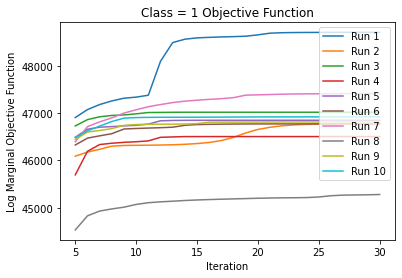

In [84]:
plt.plot(list(to_plot_dict1.keys()), list(to_plot_dict1.values()), label = "Run 1")
plt.plot(list(to_plot_dict2.keys()), list(to_plot_dict2.values()), label = "Run 2")
plt.plot(list(to_plot_dict3.keys()), list(to_plot_dict3.values()), label = "Run 3")
plt.plot(list(to_plot_dict4.keys()), list(to_plot_dict4.values()), label = "Run 4")
plt.plot(list(to_plot_dict5.keys()), list(to_plot_dict5.values()), label = "Run 5")
plt.plot(list(to_plot_dict6.keys()), list(to_plot_dict6.values()), label = "Run 6")
plt.plot(list(to_plot_dict7.keys()), list(to_plot_dict7.values()), label = "Run 7")
plt.plot(list(to_plot_dict8.keys()), list(to_plot_dict8.values()), label = "Run 8")
plt.plot(list(to_plot_dict9.keys()), list(to_plot_dict9.values()), label = "Run 9")
plt.plot(list(to_plot_dict10.keys()), list(to_plot_dict10.values()), label = "Run 10")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Log Marginal Objective Function")
plt.title("Class = 1 Objective Function")
# plt.savefig("class_1_obj_funct")

In [85]:
best = to_plot_dict1

if to_plot_dict2[30] > to_plot_dict1[30]:
    best = to_plot_dict2
if to_plot_dict3[30] > best[30]:
    best =to_plot_dict3
if to_plot_dict4[30] > best[30]:
    best =to_plot_dict4
if to_plot_dict5[30] > best[30]:
    best =to_plot_dict5
if to_plot_dict6[30] > best[30]:
    best =to_plot_dict6
if to_plot_dict7[30] > best[30]:
    best =to_plot_dict7
if to_plot_dict8[30] > best[30]:
    best =to_plot_dict8
if to_plot_dict9[30] > best[30]:
    best =to_plot_dict9
if to_plot_dict10[30] > best[30]:
    best =to_plot_dict10
    
if best == to_plot_dict1:
    use = 1
elif best == to_plot_dict2:
    use = 2
elif best == to_plot_dict3:
    use = 3
elif best == to_plot_dict4:
    use = 4
elif best == to_plot_dict5:
    use = 5
elif best == to_plot_dict6:
    use = 6
elif best == to_plot_dict7:
    use = 7
elif best == to_plot_dict8:
    use = 8
elif best == to_plot_dict9:
    use = 9
elif best == to_plot_dict10:
    use = 10

spam_probs_use = spam_test_probs[use]
spam_probs_use

{0: 334471505169577.56,
 1: 1461977529589.291,
 2: 6795444930488377.0,
 3: 213884914233571.44,
 4: 2170155334567015.5,
 5: 48911399.51831815,
 6: 106744385986268.1,
 7: 177716300619.19727,
 8: 505519669250191.2,
 9: 5592406799636.392,
 10: 2754354493423.263,
 11: 1212837345875.3123,
 12: 66361813571.55769,
 13: 363594071839.7884,
 14: 1.8586423992798184e+16,
 15: 116653022628594.39,
 16: 41200481060.31533,
 17: 36222748020873.57,
 18: 15463619604.402046,
 19: 71879894310.6684,
 20: 8446538848023.318,
 21: 346054085105158.94,
 22: 202761818358142.4,
 23: 1276037394.6717682,
 24: 723528822593893.0,
 25: 0.0014218760091272349,
 26: 3.588513249243754e+16,
 27: 501639050232786.94,
 28: 6609703717.692622,
 29: 195896.82471683787,
 30: 7029668892551.3955,
 31: 1.3099168115723898e+16,
 32: 6.091017176363702e+16,
 33: 291543686447.6443,
 34: 6.091017176363702e+16,
 35: 20448560079.639553,
 36: 1882020891.0266159,
 37: 1678132464795407.5,
 38: 3422816794397.7163,
 39: 218965589323246.5,
 40: 2.5

AGAIN BUT FOR CLASS = 0

In [86]:
#1 CLASS

why_train_use, ex_train_use, why_test_use, ex_test_use = one_class(0)

why_train_use = why_train_use.reset_index(drop = True)
ex_train_use = ex_train_use.reset_index(drop = True)
why_test_use = why_test_use.reset_index(drop = True)
ex_test_use = ex_test_use.reset_index(drop = True)

cov = np.cov(ex_train_use.T)

mean = np.mean(ex_train_use)



In [87]:
#INITIALIZE 0S/EMPTIES

phi = {}

for i in ex_train_use.index:
    phi[i] = [1/2, 1/2]
    
n_k = [0, 0]

pi_k = [1/2, 1/2]

mu_k = np.random.multivariate_normal(mean, cov, 2)

cov_k = [cov, cov]

no_spam_test_probs = {}


In [88]:
runs_0 = {}
for j in range(10):
    #INITIALIZE 0S/EMPTIES

    phi = {}
    test_probs = {}

    for i in ex_train_use.index:
        phi[i] = [1/4, 1/4, 1/4, 1/4]

    n_k = [0, 0, 0, 0]

    pi_k = [1/4, 1/4, 1/4, 1/4]

    mu_k = np.random.multivariate_normal(mean, cov, 4)

    cov_k = [cov, cov, cov, cov]

    performance = {}

    for i in range(30):
        #GET 3 PDFS
        pdf1 = stats.multivariate_normal.pdf(ex_train_use, mu_k[0], cov_k[0], allow_singular = True)
        pdf2 = stats.multivariate_normal.pdf(ex_train_use, mu_k[1], cov_k[1], allow_singular = True)
        pdf3 = stats.multivariate_normal.pdf(ex_train_use, mu_k[2], cov_k[2], allow_singular = True)
        pdf4 = stats.multivariate_normal.pdf(ex_train_use, mu_k[3], cov_k[3], allow_singular = True)

        #GET PHIs FOR EACH OBS
        update_phi_4(0, pdf1)
        update_phi_4(1, pdf2)
        update_phi_4(2, pdf3)
        update_phi_4(3, pdf4)

        #GET EACH N_k
        n_k[0] = sum([item[0] for item in phi.values()])
        n_k[1] = sum([item[1] for item in phi.values()])
        n_k[2] = sum([item[2] for item in phi.values()])
        n_k[3] = sum([item[3] for item in phi.values()])

        #UPDATE PIs
        pi_k[0] = n_k[0]/len(ex_train_use)
        pi_k[1] = n_k[1]/len(ex_train_use)
        pi_k[2] = n_k[2]/len(ex_train_use)
        pi_k[3] = n_k[3]/len(ex_train_use)

        #GET NEW MUs
        mu_1 = update_mu(0)
        mu_2 = update_mu(1)
        mu_3 = update_mu(2)
        mu_4 = update_mu(3)

        mu_k = [mu_1, mu_2, mu_3, mu_4]

        #AND NEW COVs
        cov_k = [update_cov(0), update_cov(1), update_cov(2), update_cov(3)]

        #AND LOSS FUNCTION

        final_sum = []

        for obs in ex_train_use.index:
            to_sum_k = [0, 0, 0, 0]
            to_sum_k[0] += pi_k[0] * pdf1[obs]
            to_sum_k[1] += pi_k[1] * pdf2[obs]
            to_sum_k[2] += pi_k[2] * pdf3[obs]
            to_sum_k[3] += pi_k[3] * pdf4[obs]
            summed_k = sum(to_sum_k)
            to_sum = np.log(summed_k)
            final_sum.append(to_sum)

        loss = sum(final_sum)

        performance[i + 1] = loss
        print(j, i, loss)
        
        if i + 1 == 30:
            pdf1_test = stats.multivariate_normal.pdf(ex_test, mu_k[0], cov_k[0], allow_singular = True)
            pdf2_test = stats.multivariate_normal.pdf(ex_test, mu_k[1], cov_k[1], allow_singular = True)
            pdf3_test = stats.multivariate_normal.pdf(ex_test, mu_k[2], cov_k[2], allow_singular = True)
            pdf4_test = stats.multivariate_normal.pdf(ex_test, mu_k[3], cov_k[3], allow_singular = True)
            
            for test_obs in why_test.index:
                test_probs[test_obs] = pi_k[0] * pdf1_test[test_obs] +\
                                            pi_k[1] * pdf2_test[test_obs] +\
                                        pi_k[2] * pdf3_test[test_obs] +\
                                        pi_k[3] * pdf4_test[test_obs]
            no_spam_test_probs[j + 1] = test_probs
                
    runs_0[j + 1] = performance

0 0 15808.849414107206
0 1 36962.969327188126
0 2 45510.38681895345
0 3 48365.08797215787
0 4 49276.54330179198
0 5 50251.25690805696
0 6 50633.93625113811
0 7 50813.11931697466
0 8 50926.20944560631
0 9 51017.03484286451
0 10 51098.23805159613
0 11 51200.0853705973
0 12 51276.17842395783
0 13 51377.12362567112
0 14 51577.6964210386
0 15 51835.70616739146
0 16 52034.54343826551
0 17 52211.43778238132
0 18 52420.2744584168
0 19 52655.43206621102
0 20 52896.98837492518
0 21 53125.668271542294
0 22 53374.242710076884
0 23 53581.52853999736
0 24 53731.85014963754
0 25 53821.1652541583
0 26 53886.16677758174
0 27 53942.86709251401
0 28 54010.92048240035
0 29 54075.622506063475
1 0 16398.323480696672
1 1 43300.31655236176
1 2 47350.99107440593
1 3 49401.80139933453
1 4 50432.52591928229
1 5 51318.29450719428
1 6 52127.10890034538
1 7 52992.85395344104
1 8 53751.990755356244
1 9 54090.595418231926
1 10 54296.01403542739
1 11 54474.678951542155
1 12 54616.080998769445
1 13 54836.18186787124
1 

In [89]:
performance1_0 = runs_0[1]
performance2_0 = runs_0[2]
performance3_0 = runs_0[3]
performance4_0 = runs_0[4]
performance5_0 = runs_0[5]
performance6_0 = runs_0[6]
performance7_0 = runs_0[7]
performance8_0 = runs_0[8]
performance9_0 = runs_0[9]
performance10_0 = runs_0[10]


In [90]:
to_plot_dict1_0 = {k: v for k, v in performance1_0.items() if k > 4}
to_plot_dict2_0 = {k: v for k, v in performance2_0.items() if k > 4}
to_plot_dict3_0 = {k: v for k, v in performance3_0.items() if k > 4}
to_plot_dict4_0 = {k: v for k, v in performance4_0.items() if k > 4}
to_plot_dict5_0 = {k: v for k, v in performance5_0.items() if k > 4}
to_plot_dict6_0 = {k: v for k, v in performance6_0.items() if k > 4}
to_plot_dict7_0 = {k: v for k, v in performance7_0.items() if k > 4}
to_plot_dict8_0 = {k: v for k, v in performance8_0.items() if k > 4}
to_plot_dict9_0 = {k: v for k, v in performance9_0.items() if k > 4}
to_plot_dict10_0 = {k: v for k, v in performance10_0.items() if k > 4}

Text(0.5, 1.0, 'Class = 0 Objective Function')

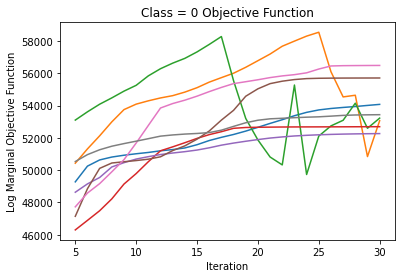

In [91]:
plt.plot(list(to_plot_dict1_0.keys()), list(to_plot_dict1_0.values()), label = "Run 1")
plt.plot(list(to_plot_dict2_0.keys()), list(to_plot_dict2_0.values()), label = "Run 2")
plt.plot(list(to_plot_dict3_0.keys()), list(to_plot_dict3_0.values()), label = "Run 3")
plt.plot(list(to_plot_dict4_0.keys()), list(to_plot_dict4_0.values()), label = "Run 4")
plt.plot(list(to_plot_dict5_0.keys()), list(to_plot_dict5_0.values()), label = "Run 5")
plt.plot(list(to_plot_dict6_0.keys()), list(to_plot_dict6_0.values()), label = "Run 6")
plt.plot(list(to_plot_dict7_0.keys()), list(to_plot_dict7_0.values()), label = "Run 7")
plt.plot(list(to_plot_dict8_0.keys()), list(to_plot_dict8_0.values()), label = "Run 8")
# # plt.plot(list(to_plot_dict9_0.keys()), list(to_plot_dict9_0.values()), label = "Run 9")
# # plt.plot(list(to_plot_dict10_0.keys()), list(to_plot_dict10_0.values()), label = "Run 10")
# plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Log Marginal Objective Function")
plt.title("Class = 0 Objective Function")
# plt.savefig("class_0_obj_funct")

In [92]:
best = to_plot_dict1_0

if to_plot_dict2_0[30] > to_plot_dict1_0[30]:
    best = to_plot_dict2_0
if to_plot_dict3_0[30] > best[30]:
    best =to_plot_dict3_0
if to_plot_dict4_0[30] > best[30]:
    best =to_plot_dict4_0
if to_plot_dict5_0[30] > best[30]:
    best =to_plot_dict5_0
if to_plot_dict6_0[30] > best[30]:
    best =to_plot_dict6_0
if to_plot_dict7_0[30] > best[30]:
    best =to_plot_dict7_0
if to_plot_dict8_0[30] > best[30]:
    best =to_plot_dict8_0
if to_plot_dict9_0[30] > best[30]:
    best =to_plot_dict9_0
if to_plot_dict10_0[30] > best[30]:
    best =to_plot_dict10_0
    
if best == to_plot_dict1_0:
    use = 1
elif best == to_plot_dict2_0:
    use = 2
elif best == to_plot_dict3_0:
    use = 3
elif best == to_plot_dict4_0:
    use = 4
elif best == to_plot_dict5_0:
    use = 5
elif best == to_plot_dict6_0:
    use = 6
elif best == to_plot_dict7_0:
    use = 7
elif best == to_plot_dict8_0:
    use = 8
elif best == to_plot_dict9_0:
    use = 9
elif best == to_plot_dict10_0:
    use = 10

no_spam_probs_use = no_spam_test_probs[use]
no_spam_probs_use

{0: 2400.4456079652878,
 1: 154361210.44129914,
 2: 719752108415812.9,
 3: 10411993943001.12,
 4: 551578497.0408757,
 5: 4.841221439098797,
 6: 968.4274654805682,
 7: 8512.697580679314,
 8: 2574786272375.2925,
 9: 552.3675025391124,
 10: 47.958196587738456,
 11: 104032.67943801143,
 12: 10728993.429695792,
 13: 121909474.8313672,
 14: 961359840.928432,
 15: 128457631.02346916,
 16: 47.26182591225218,
 17: 71843395413.77983,
 18: 2518.639406661266,
 19: 23.950934453188456,
 20: 630.4073826721348,
 21: 3011.608804963024,
 22: 1802031123.1369667,
 23: 941205958.1264261,
 24: 116070409.39898439,
 25: 925975398.3588256,
 26: 1780842855.445343,
 27: 3936659499.337628,
 28: 199.15739537667562,
 29: 0.09112068776802931,
 30: 178813.22184594916,
 31: 8222385012072.585,
 32: 13070131138.439116,
 33: 865014499278.2041,
 34: 13070131138.439116,
 35: 1552.6447810765374,
 36: 33500.273912123186,
 37: 134441091796071.69,
 38: 31545512.24427694,
 39: 116931114107.42308,
 40: 6652934750.871935,
 41: 59

In [93]:
preds = []
was_1_pred_1 = 0
was_1_pred_0 = 0
was_0_pred_1 = 0
was_0_pred_0 = 0
for i in range(len(why_test)):
    if class_1_pct * spam_probs_use[i] > class_0_pct * no_spam_probs_use[i]:
        preds.append(1)
    else:
        preds.append(0)
    if why_test.loc[i, 0] == 1 and preds[i] == 1:
        was_1_pred_1 += 1
    elif why_test.loc[i, 0] == 1 and preds[i] == 0:
        was_1_pred_0 += 1
    elif why_test.loc[i, 0] == 0 and preds[i] == 1:
        was_0_pred_1 += 1
    elif why_test.loc[i, 0] == 0 and preds[i] == 0:
        was_0_pred_0 += 1

In [94]:
[[was_1_pred_1, was_1_pred_0], [was_0_pred_1, was_0_pred_0]]

[[172, 10], [67, 211]]

In [95]:
(was_1_pred_1 + was_0_pred_0)/(was_1_pred_1 + was_1_pred_0 + was_0_pred_1 + was_0_pred_0)

0.8326086956521739

In [96]:
gmm4_cm = metrics.confusion_matrix(np.array(why_test), preds)

In [97]:
gmm4_cm

array([[211,  67],
       [ 10, 172]])

NOW 1 GMM

In [98]:
#1 CLASS

why_train_use, ex_train_use, why_test_use, ex_test_use = one_class(1)

cov = np.cov(ex_train_use.T)

mean = np.mean(ex_train_use)



In [99]:
#INITIALIZE 0S/EMPTIES

phi = {}

for i in ex_train_use.index:
    phi[i] = [1]
    
n_k = [0]

pi_k = [1]

mu_k = np.random.multivariate_normal(mean, cov, 1)

cov_k = [cov]

spam_test_probs = {}


In [100]:
runs = {}
for j in range(10):
    #INITIALIZE 0S/EMPTIES

    phi = {}
    test_probs = {}

    for i in ex_train_use.index:
        phi[i] = [1]

    n_k = [0]

    pi_k = [1]

    mu_k = np.random.multivariate_normal(mean, cov, 1)

    cov_k = [cov]

    performance = {}

    for i in range(30):
        #GET 3 PDFS
        pdf1 = stats.multivariate_normal.pdf(ex_train_use, mu_k[0], cov_k[0], allow_singular = True)

        #GET PHIs FOR EACH OBS
        update_phi(0, pdf1)

        #GET EACH N_k
        n_k[0] = sum([item[0] for item in phi.values()])

        #UPDATE PIs
        pi_k[0] = n_k[0]/len(ex_train_use)

        #GET NEW MUs
        mu_1 = update_mu(0)

        mu_k = [mu_1]

        #AND NEW COVs
        cov_k = [update_cov(0)]

        #AND LOSS FUNCTION

        final_sum = []

        for obs in ex_train_use.index:
            to_sum_k = [0]
            to_sum_k[0] += pi_k[0] * pdf1[obs]
            summed_k = sum(to_sum_k)
            to_sum = np.log(summed_k)
            final_sum.append(to_sum)

        loss = sum(final_sum)

        performance[i + 1] = loss
        print(j, i, loss)
        
        if i + 1 == 30:
            pdf1_test = stats.multivariate_normal.pdf(ex_test, mu_k[0], cov_k[0], allow_singular = True)
            
            for test_obs in why_test.index:
                test_probs[test_obs] = pi_k[0] * pdf1_test[test_obs] 
            spam_test_probs[j + 1] = test_probs
                
    runs[j + 1] = performance

0 0 18484.20621328583
0 1 27250.635479839282
0 2 27250.635479839282
0 3 27250.635479839282
0 4 27250.635479839282
0 5 27250.635479839282
0 6 27250.635479839282
0 7 27250.635479839282
0 8 27250.635479839282
0 9 27250.635479839282
0 10 27250.635479839282
0 11 27250.635479839282
0 12 27250.635479839282
0 13 27250.635479839282
0 14 27250.635479839282
0 15 27250.635479839282
0 16 27250.635479839282
0 17 27250.635479839282
0 18 27250.635479839282
0 19 27250.635479839282
0 20 27250.635479839282
0 21 27250.635479839282
0 22 27250.635479839282
0 23 27250.635479839282
0 24 27250.635479839282
0 25 27250.635479839282
0 26 27250.635479839282
0 27 27250.635479839282
0 28 27250.635479839282
0 29 27250.635479839282
1 0 18082.09293742212
1 1 27250.635479839282
1 2 27250.635479839282
1 3 27250.635479839282
1 4 27250.635479839282
1 5 27250.635479839282
1 6 27250.635479839282
1 7 27250.635479839282
1 8 27250.635479839282
1 9 27250.635479839282
1 10 27250.635479839282
1 11 27250.635479839282
1 12 27250.635

In [101]:
performance1 = runs[1]
performance2 = runs[2]
performance3 = runs[3]
performance4 = runs[4]
performance5 = runs[5]
performance6 = runs[6]
performance7 = runs[7]
performance8 = runs[8]
performance9 = runs[9]
performance10 = runs[10]


In [102]:
to_plot_dict1 = {k: v for k, v in performance1.items() if k > 4}
to_plot_dict2 = {k: v for k, v in performance2.items() if k > 4}
to_plot_dict3 = {k: v for k, v in performance3.items() if k > 4}
to_plot_dict4 = {k: v for k, v in performance4.items() if k > 4}
to_plot_dict5 = {k: v for k, v in performance5.items() if k > 4}
to_plot_dict6 = {k: v for k, v in performance6.items() if k > 4}
to_plot_dict7 = {k: v for k, v in performance7.items() if k > 4}
to_plot_dict8 = {k: v for k, v in performance8.items() if k > 4}
to_plot_dict9 = {k: v for k, v in performance9.items() if k > 4}
to_plot_dict10 = {k: v for k, v in performance10.items() if k > 4}

Text(0.5, 1.0, 'Class = 1 Objective Function')

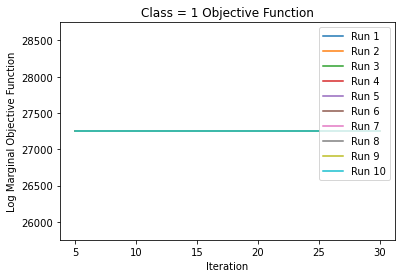

In [103]:
plt.plot(list(to_plot_dict1.keys()), list(to_plot_dict1.values()), label = "Run 1")
plt.plot(list(to_plot_dict2.keys()), list(to_plot_dict2.values()), label = "Run 2")
plt.plot(list(to_plot_dict3.keys()), list(to_plot_dict3.values()), label = "Run 3")
plt.plot(list(to_plot_dict4.keys()), list(to_plot_dict4.values()), label = "Run 4")
plt.plot(list(to_plot_dict5.keys()), list(to_plot_dict5.values()), label = "Run 5")
plt.plot(list(to_plot_dict6.keys()), list(to_plot_dict6.values()), label = "Run 6")
plt.plot(list(to_plot_dict7.keys()), list(to_plot_dict7.values()), label = "Run 7")
plt.plot(list(to_plot_dict8.keys()), list(to_plot_dict8.values()), label = "Run 8")
plt.plot(list(to_plot_dict9.keys()), list(to_plot_dict9.values()), label = "Run 9")
plt.plot(list(to_plot_dict10.keys()), list(to_plot_dict10.values()), label = "Run 10")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Log Marginal Objective Function")
plt.title("Class = 1 Objective Function")
# plt.savefig("class_1_obj_funct")

In [104]:
best = to_plot_dict1

if to_plot_dict2[30] > to_plot_dict1[30]:
    best = to_plot_dict2
if to_plot_dict3[30] > best[30]:
    best =to_plot_dict3
if to_plot_dict4[30] > best[30]:
    best =to_plot_dict4
if to_plot_dict5[30] > best[30]:
    best =to_plot_dict5
if to_plot_dict6[30] > best[30]:
    best =to_plot_dict6
if to_plot_dict7[30] > best[30]:
    best =to_plot_dict7
if to_plot_dict8[30] > best[30]:
    best =to_plot_dict8
if to_plot_dict9[30] > best[30]:
    best =to_plot_dict9
if to_plot_dict10[30] > best[30]:
    best =to_plot_dict10
    
if best == to_plot_dict1:
    use = 1
elif best == to_plot_dict2:
    use = 2
elif best == to_plot_dict3:
    use = 3
elif best == to_plot_dict4:
    use = 4
elif best == to_plot_dict5:
    use = 5
elif best == to_plot_dict6:
    use = 6
elif best == to_plot_dict7:
    use = 7
elif best == to_plot_dict8:
    use = 8
elif best == to_plot_dict9:
    use = 9
elif best == to_plot_dict10:
    use = 10

spam_probs_use = spam_test_probs[use]
spam_probs_use


{0: 916060675.3840276,
 1: 470304505.19086987,
 2: 355896271.1280907,
 3: 2765079.318527178,
 4: 1406413892.7464325,
 5: 2625.186562070998,
 6: 313771105.56859124,
 7: 18676113.38046384,
 8: 31696269.47789185,
 9: 451053851.11793727,
 10: 61358718.74119254,
 11: 59874316.081250064,
 12: 1318301401.8307898,
 13: 42862694.87746228,
 14: 1159935678.998593,
 15: 1128853886.2538362,
 16: 21293.490218012274,
 17: 1743520027.5548337,
 18: 1511696964.7028224,
 19: 4668309.759681379,
 20: 688520324.9034371,
 21: 1249786277.710283,
 22: 718562052.2480224,
 23: 243803088.87047848,
 24: 331389562.02929187,
 25: 2.682070885757026e-90,
 26: 548366361.1501667,
 27: 1760136266.0508506,
 28: 48160.63879211338,
 29: 2484113.35595069,
 30: 154640934.22166768,
 31: 959255432.3253068,
 32: 521655510.655198,
 33: 99008.98687857576,
 34: 521655510.655198,
 35: 1370587496.120752,
 36: 13696594.570970057,
 37: 397534760.9339208,
 38: 14397685.660485625,
 39: 881003424.596422,
 40: 571103768.393943,
 41: 155681

AGAIN BUT FOR CLASS = 0

In [105]:
#1 CLASS

why_train_use, ex_train_use, why_test_use, ex_test_use = one_class(0)

why_train_use = why_train_use.reset_index(drop = True)
ex_train_use = ex_train_use.reset_index(drop = True)
why_test_use = why_test_use.reset_index(drop = True)
ex_test_use = ex_test_use.reset_index(drop = True)

cov = np.cov(ex_train_use.T)

mean = np.mean(ex_train_use)



In [106]:
#INITIALIZE 0S/EMPTIES

phi = {}

for i in ex_train_use.index:
    phi[i] = [1]
    
n_k = [0]

pi_k = [1]

mu_k = np.random.multivariate_normal(mean, cov, 1)

cov_k = [cov]

no_spam_test_probs = {}


In [107]:
runs_0 = {}
for j in range(10):
    #INITIALIZE 0S/EMPTIES

    phi = {}
    test_probs = {}

    for i in ex_train_use.index:
        phi[i] = [1]

    n_k = [0]

    pi_k = [1]

    mu_k = np.random.multivariate_normal(mean, cov, 1)

    cov_k = [cov]

    performance = {}

    for i in range(30):
        #GET 3 PDFS
        pdf1 = stats.multivariate_normal.pdf(ex_train_use, mu_k[0], cov_k[0], allow_singular = True)

        #GET PHIs FOR EACH OBS
        update_phi(0, pdf1)

        #GET EACH N_k
        n_k[0] = sum([item[0] for item in phi.values()])

        #UPDATE PIs
        pi_k[0] = n_k[0]/len(ex_train_use)

        #GET NEW MUs
        mu_1 = update_mu(0)

        mu_k = [mu_1]

        #AND NEW COVs
        cov_k = [update_cov(0)]

        #AND LOSS FUNCTION

        final_sum = []

        for obs in ex_train_use.index:
            to_sum_k = [0, 0, 0, 0]
            to_sum_k[0] += pi_k[0] * pdf1[obs]
            summed_k = sum(to_sum_k)
            to_sum = np.log(summed_k)
            final_sum.append(to_sum)

        loss = sum(final_sum)

        performance[i + 1] = loss
        print(j, i, loss)
        
        if i + 1 == 30:
            pdf1_test = stats.multivariate_normal.pdf(ex_test, mu_k[0], cov_k[0], allow_singular = True)
            
            for test_obs in why_test.index:
                test_probs[test_obs] = pi_k[0] * pdf1_test[test_obs] 
            no_spam_test_probs[j + 1] = test_probs
                
    runs_0[j + 1] = performance

0 0 9866.90505365534
0 1 23112.98876555016
0 2 23112.98876555016
0 3 23112.98876555016
0 4 23112.98876555016
0 5 23112.98876555016
0 6 23112.98876555016
0 7 23112.98876555016
0 8 23112.98876555016
0 9 23112.98876555016
0 10 23112.98876555016
0 11 23112.98876555016
0 12 23112.98876555016
0 13 23112.98876555016
0 14 23112.98876555016
0 15 23112.98876555016
0 16 23112.98876555016
0 17 23112.98876555016
0 18 23112.98876555016
0 19 23112.98876555016
0 20 23112.98876555016
0 21 23112.98876555016
0 22 23112.98876555016
0 23 23112.98876555016
0 24 23112.98876555016
0 25 23112.98876555016
0 26 23112.98876555016
0 27 23112.98876555016
0 28 23112.98876555016
0 29 23112.98876555016
1 0 12556.173162227098
1 1 23112.98876555016
1 2 23112.98876555016
1 3 23112.98876555016
1 4 23112.98876555016
1 5 23112.98876555016
1 6 23112.98876555016
1 7 23112.98876555016
1 8 23112.98876555016
1 9 23112.98876555016
1 10 23112.98876555016
1 11 23112.98876555016
1 12 23112.98876555016
1 13 23112.98876555016
1 14 231

In [108]:
performance1_0 = runs_0[1]
performance2_0 = runs_0[2]
performance3_0 = runs_0[3]
performance4_0 = runs_0[4]
performance5_0 = runs_0[5]
performance6_0 = runs_0[6]
performance7_0 = runs_0[7]
performance8_0 = runs_0[8]
performance9_0 = runs_0[9]
performance10_0 = runs_0[10]


In [109]:
to_plot_dict1_0 = {k: v for k, v in performance1_0.items() if k > 4}
to_plot_dict2_0 = {k: v for k, v in performance2_0.items() if k > 4}
to_plot_dict3_0 = {k: v for k, v in performance3_0.items() if k > 4}
to_plot_dict4_0 = {k: v for k, v in performance4_0.items() if k > 4}
to_plot_dict5_0 = {k: v for k, v in performance5_0.items() if k > 4}
to_plot_dict6_0 = {k: v for k, v in performance6_0.items() if k > 4}
to_plot_dict7_0 = {k: v for k, v in performance7_0.items() if k > 4}
to_plot_dict8_0 = {k: v for k, v in performance8_0.items() if k > 4}
to_plot_dict9_0 = {k: v for k, v in performance9_0.items() if k > 4}
to_plot_dict10_0 = {k: v for k, v in performance10_0.items() if k > 4}

Text(0.5, 1.0, 'Class = 0 Objective Function')

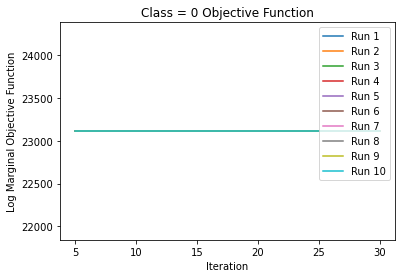

In [110]:
plt.plot(list(to_plot_dict1_0.keys()), list(to_plot_dict1_0.values()), label = "Run 1")
plt.plot(list(to_plot_dict2_0.keys()), list(to_plot_dict2_0.values()), label = "Run 2")
plt.plot(list(to_plot_dict3_0.keys()), list(to_plot_dict3_0.values()), label = "Run 3")
plt.plot(list(to_plot_dict4_0.keys()), list(to_plot_dict4_0.values()), label = "Run 4")
plt.plot(list(to_plot_dict5_0.keys()), list(to_plot_dict5_0.values()), label = "Run 5")
plt.plot(list(to_plot_dict6_0.keys()), list(to_plot_dict6_0.values()), label = "Run 6")
plt.plot(list(to_plot_dict7_0.keys()), list(to_plot_dict7_0.values()), label = "Run 7")
plt.plot(list(to_plot_dict8_0.keys()), list(to_plot_dict8_0.values()), label = "Run 8")
plt.plot(list(to_plot_dict9_0.keys()), list(to_plot_dict9_0.values()), label = "Run 9")
plt.plot(list(to_plot_dict10_0.keys()), list(to_plot_dict10_0.values()), label = "Run 10")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Log Marginal Objective Function")
plt.title("Class = 0 Objective Function")
# plt.savefig("class_0_obj_funct")

In [111]:
best = to_plot_dict1_0

if to_plot_dict2_0[30] > to_plot_dict1_0[30]:
    best = to_plot_dict2_0
if to_plot_dict3_0[30] > best[30]:
    best =to_plot_dict3_0
if to_plot_dict4_0[30] > best[30]:
    best =to_plot_dict4_0
if to_plot_dict5_0[30] > best[30]:
    best =to_plot_dict5_0
if to_plot_dict6_0[30] > best[30]:
    best =to_plot_dict6_0
if to_plot_dict7_0[30] > best[30]:
    best =to_plot_dict7_0
if to_plot_dict8_0[30] > best[30]:
    best =to_plot_dict8_0
if to_plot_dict9_0[30] > best[30]:
    best =to_plot_dict9_0
if to_plot_dict10_0[30] > best[30]:
    best =to_plot_dict10_0
    
if best == to_plot_dict1_0:
    use = 1
elif best == to_plot_dict2_0:
    use = 2
elif best == to_plot_dict3_0:
    use = 3
elif best == to_plot_dict4_0:
    use = 4
elif best == to_plot_dict5_0:
    use = 5
elif best == to_plot_dict6_0:
    use = 6
elif best == to_plot_dict7_0:
    use = 7
elif best == to_plot_dict8_0:
    use = 8
elif best == to_plot_dict9_0:
    use = 9
elif best == to_plot_dict10_0:
    use = 10

no_spam_probs_use = no_spam_test_probs[use]
no_spam_probs_use


{0: 767115.9717514305,
 1: 300430.00915026857,
 2: 574062.1960013738,
 3: 404447.15084203845,
 4: 503155.6004019099,
 5: 1075.9116986834274,
 6: 803503.7200251423,
 7: 23.078091197215244,
 8: 54271.22023987881,
 9: 47310.63251254088,
 10: 4608.078598770738,
 11: 231427.3744851357,
 12: 1000129.5049194719,
 13: 345197.03585478035,
 14: 608692.8535225608,
 15: 288951.4073826159,
 16: 1.916751749853083e-17,
 17: 647395.14066075,
 18: 647102.616142694,
 19: 2524.3807148262003,
 20: 61343.32408895878,
 21: 647469.3646036971,
 22: 107570.93027950832,
 23: 616315.8539282369,
 24: 99542.26762670629,
 25: 393712.9915614467,
 26: 15825.312934171017,
 27: 847597.7916996357,
 28: 33054.151374779525,
 29: 652.4477833386404,
 30: 4428.113246064935,
 31: 676690.7153110858,
 32: 19337.319380052315,
 33: 369213.0292517248,
 34: 19337.319380052315,
 35: 420261.7845219854,
 36: 600314.0977298726,
 37: 621906.7527731099,
 38: 20756.24200348588,
 39: 459615.2584727269,
 40: 52261.472988020374,
 41: 829228.

In [112]:
preds = []
was_1_pred_1 = 0
was_1_pred_0 = 0
was_0_pred_1 = 0
was_0_pred_0 = 0
for i in range(len(why_test)):
    if class_1_pct * spam_probs_use[i] > class_0_pct * no_spam_probs_use[i]:
        preds.append(1)
    else:
        preds.append(0)
    if why_test.loc[i, 0] == 1 and preds[i] == 1:
        was_1_pred_1 += 1
    elif why_test.loc[i, 0] == 1 and preds[i] == 0:
        was_1_pred_0 += 1
    elif why_test.loc[i, 0] == 0 and preds[i] == 1:
        was_0_pred_1 += 1
    elif why_test.loc[i, 0] == 0 and preds[i] == 0:
        was_0_pred_0 += 1

In [113]:
[[was_1_pred_1, was_1_pred_0], [was_0_pred_1, was_0_pred_0]]

[[174, 8], [96, 182]]

In [114]:
(was_1_pred_1 + was_0_pred_0)/(was_1_pred_1 + was_1_pred_0 + was_0_pred_1 + was_0_pred_0)

0.7739130434782608

In [115]:
gmm1_cm = metrics.confusion_matrix(np.array(why_test), preds)

In [116]:
gmm1_cm

array([[182,  96],
       [  8, 174]])